# Implementation of a KAN for classification
In this notebook I implement a Kolmogorov-Arnold Network (KAN) for the use of classification and compare it against a neural network of a similar architecture.

## Initialisations

## Creating and Training the KAN

In [1]:
from fastkan import FastKAN as KAN 
import pandas as pd  
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
from torchvision.datasets import ImageFolder
import random
import os
import shutil
from scipy.stats import poisson
# Display the noisy images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [2]:
# Checking for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
"""def split_dataset(source_dir, train_dir, val_dir, val_ratio=0.2):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            random.shuffle(images)
            val_size = int(len(images) * val_ratio)

            for i, img in enumerate(images):
                src_path = os.path.join(category_path, img)
                if i < val_size:
                    dest_dir = os.path.join(val_dir, category)
                else:
                    dest_dir = os.path.join(train_dir, category)

                if not os.path.exists(dest_dir):
                    os.makedirs(dest_dir)
                
                shutil.copy(src_path, dest_dir)

source_directory = 'C:\\Users\\Moneeb Raza\\Downloads\\KAN\KAN-master\\data\caltech101\\101_ObjectCategories'
train_directory = './data/caltech101/train'
val_directory = './data/caltech101/val'

split_dataset(source_directory, train_directory, val_directory)"""

<>:1: SyntaxWarning: invalid escape sequence '\K'
<>:1: SyntaxWarning: invalid escape sequence '\K'
C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_5928\1134296264.py:1: SyntaxWarning: invalid escape sequence '\K'
  """def split_dataset(source_dir, train_dir, val_dir, val_ratio=0.2):


"def split_dataset(source_dir, train_dir, val_dir, val_ratio=0.2):\n    if not os.path.exists(train_dir):\n        os.makedirs(train_dir)\n    if not os.path.exists(val_dir):\n        os.makedirs(val_dir)\n\n    for category in os.listdir(source_dir):\n        category_path = os.path.join(source_dir, category)\n        if os.path.isdir(category_path):\n            images = os.listdir(category_path)\n            random.shuffle(images)\n            val_size = int(len(images) * val_ratio)\n\n            for i, img in enumerate(images):\n                src_path = os.path.join(category_path, img)\n                if i < val_size:\n                    dest_dir = os.path.join(val_dir, category)\n                else:\n                    dest_dir = os.path.join(train_dir, category)\n\n                if not os.path.exists(dest_dir):\n                    os.makedirs(dest_dir)\n                \n                shutil.copy(src_path, dest_dir)\n\nsource_directory = 'C:\\Users\\Moneeb Raza\\Down

In [4]:
class AddGaussianNoise:
    def __init__(self, mean=0, var=0.021):
        self.mean = mean
        self.var = var

    def __call__(self, image):
        sigma = self.var ** 0.5
        gaussian = np.random.normal(self.mean, sigma, image.shape)
        noisy_image = np.clip(image + gaussian, 0, 1)
        return torch.tensor(noisy_image).float()

class AddSpeckleNoise:
    def __init__(self, mean=0, var=0.0013):
        self.mean = mean
        self.var = var

    def __call__(self, image):
        gaussian = np.random.normal(self.mean, self.var ** 0.5, image.shape)
        noisy_image = np.clip(image + image * gaussian, 0, 1)
        return torch.tensor(noisy_image).float()

class AddSaltAndPepperNoise:
    def __init__(self, salt_prob=0.9999, pepper_prob=0.9999):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob

    def __call__(self, image):
        noisy_image = image
        salt_mask = np.random.choice([0, 1], size=image.shape, p=[1 - self.salt_prob, self.salt_prob])
        pepper_mask = np.random.choice([0, 1], size=image.shape, p=[1 - self.pepper_prob, self.pepper_prob])
        noisy_image[salt_mask == 1] = 1
        noisy_image[pepper_mask == 1] = 0
        return torch.tensor(noisy_image).float()

class AddPoissonNoise:
    def __init__(self, scale_factor=1470, clip_min=0, clip_max=1):
        self.scale_factor = scale_factor
        self.clip_min = clip_min
        self.clip_max = clip_max

    def __call__(self, image):
        if self.scale_factor is None:
            vals = len(np.unique(image))
            scale_factor = 2 ** np.ceil(np.log2(vals))
        else:
            scale_factor = self.scale_factor

        noisy_image = np.random.poisson(image * scale_factor) / float(scale_factor)
        noisy_image = np.clip(noisy_image, self.clip_min, self.clip_max)
        return torch.tensor(noisy_image).float()

class AddOcclusionNoise:
    def __init__(self, size=0.2995):
        self.size = size

    def __call__(self, image):
        noisy_image = image
        h, w, _ = image.shape
        occlusion_size = int(min(h, w) * self.size)
        x = random.randint(0, w - occlusion_size)
        y = random.randint(0, h - occlusion_size)
        noisy_image[y:y+occlusion_size, x:x+occlusion_size] = 0
        return torch.tensor(noisy_image).float()

In [5]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize images to 96x96
    transforms.ToTensor(),
    AddGaussianNoise(),
    #AddSpeckleNoise(),
    #AddSaltAndPepperNoise(),
    #AddPoissonNoise(),
    #AddOcclusionNoise(),
])
transform_test = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize images to 96x96
    transforms.ToTensor(),
    AddGaussianNoise(),
    #AddSpeckleNoise(),
    #AddSaltAndPepperNoise(),
    #AddPoissonNoise(),
    #AddOcclusionNoise(),
])


# Load the Caltech 101 dataset
trainset = ImageFolder(root="C:\\Users\\Moneeb Raza\\Downloads\\KAN\\KAN-master\\KAN-Image based Noise\\data\\caltech101\\train\\", transform=transform)
valset = ImageFolder(root="C:\\Users\\Moneeb Raza\\Downloads\\KAN\\KAN-master\\KAN-Image based Noise\\data\\caltech101\\val\\", transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=False)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [5]:
# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)
copyImages = images.clone()

In [6]:
noisy_images_gaussian = torch.stack([AddSaltAndPepperNoise()(img.permute(1, 2, 0)) for img in images]).permute(0, 3, 1, 2)

C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_25016\2886237154.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_image).float()


Mean PSNR: 5.630223336561324


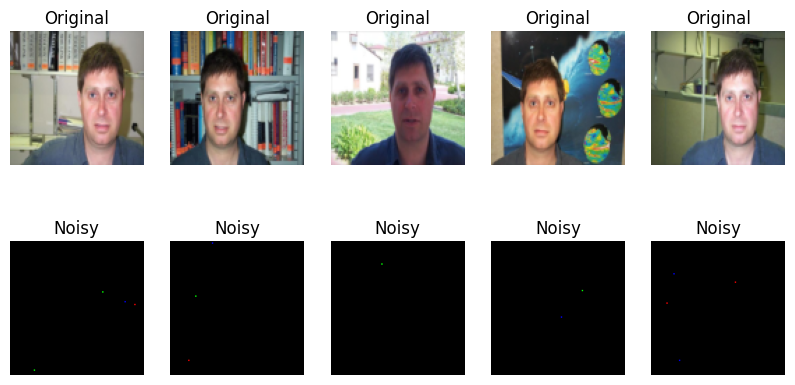

Mean SSIM: 0.0010114588076248765


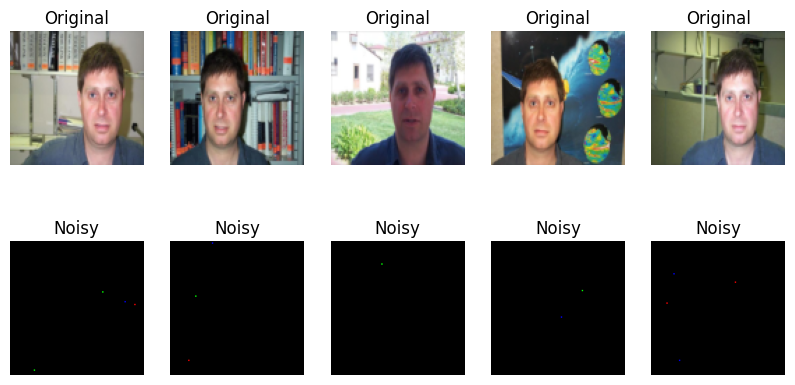

In [7]:
def calculate_psnr_batch(original, noisy,device= 'cuda'):
    original = original.to(device)
    noisy = noisy.to(device)
    batch_size = original.shape[0]
    psnr_values = []
    for i in range(batch_size):
        mse = torch.mean((original[i] - noisy[i]) ** 2).item()
        if mse == 0:
            psnr_values.append(100)
        else:
            max_pixel = 1.0
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    return np.mean(psnr_values)

def calculate_ssim_batch(original, noisy):
    batch_size = original.shape[0]
    ssim_values = []
    for i in range(batch_size):
        ssim_value = ssim(
            original[i].permute(1, 2, 0).numpy(),
            noisy[i].permute(1, 2, 0).numpy(),
            win_size=3,
            channel_axis=2,
            data_range=1.0
        )
        ssim_values.append(ssim_value)
    return np.mean(ssim_values)

# Calculate PSNR and SSIM for the test set
psnr_values = calculate_psnr_batch(copyImages[:5], noisy_images_gaussian[:5])
mean_psnr = np.mean(psnr_values)
print(f'Mean PSNR: {mean_psnr}')

n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(np.transpose(copyImages[i], (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2, n, i+n+1)
    plt.imshow(np.transpose(noisy_images_gaussian[i], (1, 2, 0)))
    plt.title("Noisy")
    plt.axis('off')
plt.show()

ssim_values = calculate_ssim_batch(copyImages[:5], noisy_images_gaussian[:5])


mean_ssim = np.mean(ssim_values)


print(f'Mean SSIM: {mean_ssim}')

n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(np.transpose(copyImages[i], (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2, n, i+n+1)
    plt.imshow(np.transpose(noisy_images_gaussian[i], (1, 2, 0)))
    plt.title("Noisy")
    plt.axis('off')
plt.show()

Optimizers

In [6]:
# Define the KAN model with output size of 10 for Caltech-101
model = KAN([96*96*3, 256, 512, 512, 512, 1024, 102])  # Adjust input size to 96*96*3 for Caltech-101
model.to(device)
# Define Adam optimizer
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Define learning rate scheduler
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
# Define AdamW optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [7]:
criterion = nn.BCEWithLogitsLoss()

In [8]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(600):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    trainnoiseerror = 0.0
    with tqdm(train_loader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 96*96*3).to(device)
            optimizer.zero_grad()
            features = model(images)
            #print(labels.shape)
            labels_one_hot = torch.eye(102)[labels].to(device)  # Change to 101 caltech
            loss = criterion(features, labels_one_hot)
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, predicted_labels = torch.max(features, 1)
            accuracy = (predicted_labels == labels.to(device)).float().mean()
            
            running_loss += loss.item()
            running_accuracy += accuracy.item()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 96*96*3).to(device)
            output = model(images)
            
            labels_one_hot = torch.eye(102)[labels].to(device)  # Change to 101 caltech
            val_loss += criterion(output, labels_one_hot).item()
            
            # Compute accuracy
            _, predicted_labels = torch.max(output, 1)
            val_accuracy += (predicted_labels == labels.to(device)).float().mean().item()

    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")


  0%|          | 0/115 [00:00<?, ?it/s]C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_5928\2317397194.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_image).float()
100%|██████████| 115/115 [00:36<00:00,  3.19it/s, accuracy=0, loss=0.266, lr=0.001]    


Epoch 1, Train Loss: 0.2026424369871907, Train Accuracy: 0.26942934782608696, Val Loss: 0.20465465980981076, Val Accuracy: 0.0035714288907391684


100%|██████████| 115/115 [00:35<00:00,  3.25it/s, accuracy=0, loss=0.144, lr=0.0008]    


Epoch 2, Train Loss: 0.15050421999389388, Train Accuracy: 0.2376358695652174, Val Loss: 0.17197432528649056, Val Accuracy: 0.007589285927159446


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.132, lr=0.00064]     


Epoch 3, Train Loss: 0.13650015484482023, Train Accuracy: 0.20543478260869566, Val Loss: 0.1899889042334897, Val Accuracy: 0.006547619189534869


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.116, lr=0.000512]     


Epoch 4, Train Loss: 0.1243597204765968, Train Accuracy: 0.20040760869565216, Val Loss: 0.12125294722084488, Val Accuracy: 0.006547619189534869


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.107, lr=0.00041]    


Epoch 5, Train Loss: 0.11152849380463442, Train Accuracy: 0.16494565217391305, Val Loss: 0.11553607561758586, Val Accuracy: 0.013504464445369584


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.12, lr=0.000328]     


Epoch 6, Train Loss: 0.1082673369031197, Train Accuracy: 0.16820652173913042, Val Loss: 0.12827139287920936, Val Accuracy: 0.026450893176453456


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.1, lr=0.000262]      


Epoch 7, Train Loss: 0.10530584341638884, Train Accuracy: 0.1403532608695652, Val Loss: 0.11297413420730404, Val Accuracy: 0.026450893176453456


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0674, lr=0.00021]   


Epoch 8, Train Loss: 0.08676212777980886, Train Accuracy: 0.12866847826086958, Val Loss: 0.09494502197152802, Val Accuracy: 0.026450893176453456


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0548, lr=0.000168]   


Epoch 9, Train Loss: 0.08330155190677666, Train Accuracy: 0.1, Val Loss: 0.09522673707189304, Val Accuracy: 0.02574404768113579


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0865, lr=0.000134]   


Epoch 10, Train Loss: 0.0844067769135227, Train Accuracy: 0.09578804347826086, Val Loss: 0.09876516468024679, Val Accuracy: 0.025334821747882024


100%|██████████| 115/115 [00:34<00:00,  3.35it/s, accuracy=0, loss=0.0694, lr=0.000107]    


Epoch 11, Train Loss: 0.08872324587858242, Train Accuracy: 0.026630434782608695, Val Loss: 0.07904729739363704, Val Accuracy: 0.026413690564887866


100%|██████████| 115/115 [00:34<00:00,  3.34it/s, accuracy=0, loss=0.068, lr=8.59e-5]    


Epoch 12, Train Loss: 0.07510858341727568, Train Accuracy: 0.001766304347826087, Val Loss: 0.07240660169294902, Val Accuracy: 0.022395833395421505


100%|██████████| 115/115 [00:34<00:00,  3.34it/s, accuracy=0, loss=0.0677, lr=6.87e-5]   


Epoch 13, Train Loss: 0.07141594193551852, Train Accuracy: 0.004891304347826087, Val Loss: 0.06474366318434477, Val Accuracy: 0.027455357302512442


100%|██████████| 115/115 [00:34<00:00,  3.34it/s, accuracy=0, loss=0.0642, lr=5.5e-5]   


Epoch 14, Train Loss: 0.06526899417133435, Train Accuracy: 0.017391304347826087, Val Loss: 0.05875260303063052, Val Accuracy: 0.023102678890739168


100%|██████████| 115/115 [00:34<00:00,  3.34it/s, accuracy=0, loss=0.0638, lr=4.4e-5]    


Epoch 15, Train Loss: 0.06164953886814739, Train Accuracy: 0.01847826086956522, Val Loss: 0.05637009109237364, Val Accuracy: 0.01793154768113579


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.0617, lr=3.52e-5]    


Epoch 16, Train Loss: 0.05895466258668381, Train Accuracy: 0.04442934782608696, Val Loss: 0.05366117041558027, Val Accuracy: 0.04136904768113579


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.061, lr=2.81e-5]     


Epoch 17, Train Loss: 0.056745856441557406, Train Accuracy: 0.05570652173913043, Val Loss: 0.051150565567825525, Val Accuracy: 0.13563988098342503


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.0601, lr=2.25e-5]    


Epoch 18, Train Loss: 0.05485312417149544, Train Accuracy: 0.07391304347826087, Val Loss: 0.04986703708501799, Val Accuracy: 0.18251488098342503


100%|██████████| 115/115 [00:34<00:00,  3.34it/s, accuracy=0, loss=0.0597, lr=1.8e-5]    


Epoch 19, Train Loss: 0.053366773186818414, Train Accuracy: 0.0907608695652174, Val Loss: 0.049005810503980944, Val Accuracy: 0.18359375


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.0594, lr=1.44e-5]   


Epoch 20, Train Loss: 0.05214913519828216, Train Accuracy: 0.11182065217391304, Val Loss: 0.048348190395959785, Val Accuracy: 0.18303571428571427


100%|██████████| 115/115 [00:34<00:00,  3.35it/s, accuracy=0, loss=0.0593, lr=1.15e-5]    


Epoch 21, Train Loss: 0.05109237623603448, Train Accuracy: 0.13179347826086957, Val Loss: 0.04788738429280264, Val Accuracy: 0.19084821428571427


100%|██████████| 115/115 [00:34<00:00,  3.34it/s, accuracy=0, loss=0.0592, lr=9.22e-6]    


Epoch 22, Train Loss: 0.050241122597261614, Train Accuracy: 0.14782608695652175, Val Loss: 0.047557525536311526, Val Accuracy: 0.1875


100%|██████████| 115/115 [00:34<00:00,  3.34it/s, accuracy=0, loss=0.0591, lr=7.38e-6]    


Epoch 23, Train Loss: 0.04957018961077151, Train Accuracy: 0.16141304347826088, Val Loss: 0.04732679981472237, Val Accuracy: 0.19029017857142858


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.0591, lr=5.9e-6]   


Epoch 24, Train Loss: 0.04901003409986911, Train Accuracy: 0.1751358695652174, Val Loss: 0.04715395658942206, Val Accuracy: 0.19475446428571427


100%|██████████| 115/115 [00:34<00:00,  3.34it/s, accuracy=0, loss=0.0591, lr=4.72e-6]   


Epoch 25, Train Loss: 0.0485579997058148, Train Accuracy: 0.1797554347826087, Val Loss: 0.047051244182512164, Val Accuracy: 0.19196428571428573


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.059, lr=3.78e-6]    


Epoch 26, Train Loss: 0.048199262891126714, Train Accuracy: 0.18546195652173914, Val Loss: 0.046994089714384506, Val Accuracy: 0.19419642857142858


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=3.02e-6]   


Epoch 27, Train Loss: 0.047927760778237946, Train Accuracy: 0.1857336956521739, Val Loss: 0.04693207168020308, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:46<00:00,  2.48it/s, accuracy=0, loss=0.0591, lr=2.42e-6]   


Epoch 28, Train Loss: 0.04771029309410116, Train Accuracy: 0.18845108695652174, Val Loss: 0.046849516952144246, Val Accuracy: 0.19363839285714285


100%|██████████| 115/115 [00:47<00:00,  2.42it/s, accuracy=0, loss=0.0589, lr=1.93e-6]   


Epoch 29, Train Loss: 0.04750472456216812, Train Accuracy: 0.19130434782608696, Val Loss: 0.046846160698415976, Val Accuracy: 0.19363839285714285


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.0591, lr=1.55e-6]   


Epoch 30, Train Loss: 0.0473445123952368, Train Accuracy: 0.1907608695652174, Val Loss: 0.046797591427873285, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.059, lr=1.24e-6]    


Epoch 31, Train Loss: 0.04720987283179293, Train Accuracy: 0.1938858695652174, Val Loss: 0.04675050671877606, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.059, lr=9.9e-7]    


Epoch 32, Train Loss: 0.047103419365442316, Train Accuracy: 0.19307065217391303, Val Loss: 0.046772058554259796, Val Accuracy: 0.19419642857142858


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.059, lr=7.92e-7]    


Epoch 33, Train Loss: 0.047041965883387174, Train Accuracy: 0.1967391304347826, Val Loss: 0.04674061427691153, Val Accuracy: 0.19475446428571427


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.0589, lr=6.34e-7]   


Epoch 34, Train Loss: 0.04700111791329539, Train Accuracy: 0.19483695652173913, Val Loss: 0.0467453835132931, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0591, lr=5.07e-7]   


Epoch 35, Train Loss: 0.046934650684504406, Train Accuracy: 0.19619565217391305, Val Loss: 0.0467513085875128, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=4.06e-7]    


Epoch 36, Train Loss: 0.04689988585431939, Train Accuracy: 0.19592391304347825, Val Loss: 0.04672832500987819, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0588, lr=3.25e-7]   


Epoch 37, Train Loss: 0.046851911760218766, Train Accuracy: 0.19578804347826087, Val Loss: 0.04675412703571575, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.059, lr=2.6e-7]    


Epoch 38, Train Loss: 0.0468202855437994, Train Accuracy: 0.1967391304347826, Val Loss: 0.046664000189464004, Val Accuracy: 0.19475446428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.08e-7]   


Epoch 39, Train Loss: 0.04681994389418675, Train Accuracy: 0.19605978260869567, Val Loss: 0.04671191444088306, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0588, lr=1.66e-7]   


Epoch 40, Train Loss: 0.046795472510806894, Train Accuracy: 0.19904891304347827, Val Loss: 0.046683116050969274, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0589, lr=1.33e-7]   


Epoch 41, Train Loss: 0.04677964770437583, Train Accuracy: 0.1967391304347826, Val Loss: 0.046693721786141396, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.059, lr=1.06e-7]    


Epoch 42, Train Loss: 0.04676557306362235, Train Accuracy: 0.19701086956521738, Val Loss: 0.04671117972715625, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=8.51e-8]   


Epoch 43, Train Loss: 0.04673907300862281, Train Accuracy: 0.19796195652173912, Val Loss: 0.04670525362182941, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0591, lr=6.81e-8]   


Epoch 44, Train Loss: 0.04676221818865641, Train Accuracy: 0.19741847826086956, Val Loss: 0.046688578823315244, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=5.44e-8]    


Epoch 45, Train Loss: 0.046743269135122716, Train Accuracy: 0.19741847826086956, Val Loss: 0.04672033010449793, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=4.36e-8]   


Epoch 46, Train Loss: 0.046731749379440496, Train Accuracy: 0.19660326086956523, Val Loss: 0.04671168656620596, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.0591, lr=3.48e-8]   


Epoch 47, Train Loss: 0.046727630018216115, Train Accuracy: 0.19809782608695653, Val Loss: 0.04667365271598101, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0591, lr=2.79e-8]   


Epoch 48, Train Loss: 0.046725122144688734, Train Accuracy: 0.1982336956521739, Val Loss: 0.046706343934472115, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.059, lr=2.23e-8]    


Epoch 49, Train Loss: 0.046718349842273674, Train Accuracy: 0.1986413043478261, Val Loss: 0.046751873002254536, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0588, lr=1.78e-8]   


Epoch 50, Train Loss: 0.04672949917452491, Train Accuracy: 0.19809782608695653, Val Loss: 0.04672109984260585, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.059, lr=1.43e-8]    


Epoch 51, Train Loss: 0.04670880057079636, Train Accuracy: 0.19945652173913042, Val Loss: 0.04670458047517708, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0589, lr=1.14e-8]   


Epoch 52, Train Loss: 0.046725116281405736, Train Accuracy: 0.19796195652173912, Val Loss: 0.04666756346289601, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=9.13e-9]    


Epoch 53, Train Loss: 0.04672441265505293, Train Accuracy: 0.19932065217391304, Val Loss: 0.046730469745982973, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=7.31e-9]   


Epoch 54, Train Loss: 0.04672370119749204, Train Accuracy: 0.1985054347826087, Val Loss: 0.046723930830402036, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=5.85e-9]    


Epoch 55, Train Loss: 0.046734054661963294, Train Accuracy: 0.1971467391304348, Val Loss: 0.046690023537459116, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0589, lr=4.68e-9]   


Epoch 56, Train Loss: 0.0467095543185006, Train Accuracy: 0.19660326086956523, Val Loss: 0.04667965968006423, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.059, lr=3.74e-9]    


Epoch 57, Train Loss: 0.046714986974130505, Train Accuracy: 0.1998641304347826, Val Loss: 0.04674233466253749, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.059, lr=2.99e-9]    


Epoch 58, Train Loss: 0.04673139245613762, Train Accuracy: 0.1952445652173913, Val Loss: 0.0467083536620651, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=2.39e-9]   


Epoch 59, Train Loss: 0.04674480018084464, Train Accuracy: 0.1971467391304348, Val Loss: 0.04671966510691813, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=1.92e-9]    


Epoch 60, Train Loss: 0.04670945712081764, Train Accuracy: 0.19918478260869565, Val Loss: 0.04670678398438862, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=1.53e-9]    


Epoch 61, Train Loss: 0.04672321541963712, Train Accuracy: 0.19796195652173912, Val Loss: 0.046683403031368344, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0588, lr=1.23e-9]   


Epoch 62, Train Loss: 0.046725823292913644, Train Accuracy: 0.19646739130434782, Val Loss: 0.046668404480442405, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=9.81e-10]    


Epoch 63, Train Loss: 0.04670829291091017, Train Accuracy: 0.1983695652173913, Val Loss: 0.046698274689593484, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=7.85e-10]    


Epoch 64, Train Loss: 0.04673358178495065, Train Accuracy: 0.19796195652173912, Val Loss: 0.0467025527531015, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=6.28e-10]   


Epoch 65, Train Loss: 0.046722570442311144, Train Accuracy: 0.19918478260869565, Val Loss: 0.046723932859354785, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=5.02e-10]    


Epoch 66, Train Loss: 0.04673770654784597, Train Accuracy: 0.19619565217391305, Val Loss: 0.04666107051473643, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0589, lr=4.02e-10]   


Epoch 67, Train Loss: 0.046716646291315556, Train Accuracy: 0.1986413043478261, Val Loss: 0.04669944626013083, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0589, lr=3.21e-10]   


Epoch 68, Train Loss: 0.04670675271393164, Train Accuracy: 0.19945652173913042, Val Loss: 0.04670121141576341, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=2.57e-10]    


Epoch 69, Train Loss: 0.04673132315763961, Train Accuracy: 0.19660326086956523, Val Loss: 0.04669426315064941, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.059, lr=2.06e-10]    


Epoch 70, Train Loss: 0.046713707134451554, Train Accuracy: 0.1967391304347826, Val Loss: 0.04672150659774031, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.33it/s, accuracy=0, loss=0.0589, lr=1.65e-10]   


Epoch 71, Train Loss: 0.046718051956723565, Train Accuracy: 0.19741847826086956, Val Loss: 0.04672747364799891, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=1.32e-10]    


Epoch 72, Train Loss: 0.04670907123743192, Train Accuracy: 0.19605978260869567, Val Loss: 0.046717432560399175, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.05e-10]    


Epoch 73, Train Loss: 0.04671305324882269, Train Accuracy: 0.1998641304347826, Val Loss: 0.04667086263985506, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=8.42e-11]   


Epoch 74, Train Loss: 0.04671757263333901, Train Accuracy: 0.19755434782608697, Val Loss: 0.04668945795856416, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=6.74e-11]    


Epoch 75, Train Loss: 0.046711949105172054, Train Accuracy: 0.19809782608695653, Val Loss: 0.046675345760637095, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=5.39e-11]   


Epoch 76, Train Loss: 0.046721267635407654, Train Accuracy: 0.19619565217391305, Val Loss: 0.04668371076695621, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=4.31e-11]    


Epoch 77, Train Loss: 0.04671827089851317, Train Accuracy: 0.1967391304347826, Val Loss: 0.04670219253083425, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=3.45e-11]    


Epoch 78, Train Loss: 0.04671621223830658, Train Accuracy: 0.19728260869565217, Val Loss: 0.04670994911741998, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0591, lr=2.76e-11]   


Epoch 79, Train Loss: 0.04671231389207684, Train Accuracy: 0.19728260869565217, Val Loss: 0.04668998255926583, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=2.21e-11]    


Epoch 80, Train Loss: 0.04671878530441419, Train Accuracy: 0.1971467391304348, Val Loss: 0.04672360430205507, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=1.77e-11]    


Epoch 81, Train Loss: 0.04671830690425375, Train Accuracy: 0.19755434782608697, Val Loss: 0.04670757308070149, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0591, lr=1.41e-11]   


Epoch 82, Train Loss: 0.046729383342292, Train Accuracy: 0.19592391304347825, Val Loss: 0.04669243735926492, Val Accuracy: 0.20368303571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.13e-11]    


Epoch 83, Train Loss: 0.04672062977662553, Train Accuracy: 0.19646739130434782, Val Loss: 0.04670694300771824, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=9.05e-12]   


Epoch 84, Train Loss: 0.046708760175692, Train Accuracy: 0.1985054347826087, Val Loss: 0.046630004520661066, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=7.24e-12]   


Epoch 85, Train Loss: 0.046726240007125816, Train Accuracy: 0.19809782608695653, Val Loss: 0.04670525056176952, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=5.79e-12]    


Epoch 86, Train Loss: 0.04673333620733541, Train Accuracy: 0.19769021739130435, Val Loss: 0.04666466944451843, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=4.63e-12]    


Epoch 87, Train Loss: 0.04669477431022603, Train Accuracy: 0.1986413043478261, Val Loss: 0.04673868816878114, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=3.71e-12]    


Epoch 88, Train Loss: 0.04672941554175771, Train Accuracy: 0.19728260869565217, Val Loss: 0.0466806719611798, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=2.96e-12]    


Epoch 89, Train Loss: 0.04672663355165202, Train Accuracy: 0.19551630434782608, Val Loss: 0.04669600602106324, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=2.37e-12]   


Epoch 90, Train Loss: 0.04673070997485648, Train Accuracy: 0.19578804347826087, Val Loss: 0.04667109274305403, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.9e-12]    


Epoch 91, Train Loss: 0.04672668156740458, Train Accuracy: 0.19918478260869565, Val Loss: 0.04667052244102316, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.0588, lr=1.52e-12]   


Epoch 92, Train Loss: 0.04670958537608385, Train Accuracy: 0.19972826086956522, Val Loss: 0.046661627146282365, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.21e-12]   


Epoch 93, Train Loss: 0.04673558348870796, Train Accuracy: 0.196875, Val Loss: 0.04671515560975032, Val Accuracy: 0.19475446428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=9.71e-13]    


Epoch 94, Train Loss: 0.04671534252069567, Train Accuracy: 0.19701086956521738, Val Loss: 0.0467110146502299, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=7.77e-13]   


Epoch 95, Train Loss: 0.04672046244630347, Train Accuracy: 0.1953804347826087, Val Loss: 0.046712990351287384, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=6.22e-13]    


Epoch 96, Train Loss: 0.04671732712860988, Train Accuracy: 0.19891304347826086, Val Loss: 0.04668427953895714, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=4.97e-13]    


Epoch 97, Train Loss: 0.0467052445706466, Train Accuracy: 0.19592391304347825, Val Loss: 0.046722975526271124, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=3.98e-13]   


Epoch 98, Train Loss: 0.04672298037811466, Train Accuracy: 0.1967391304347826, Val Loss: 0.04666493646800518, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0588, lr=3.18e-13]   


Epoch 99, Train Loss: 0.04673327240768982, Train Accuracy: 0.19904891304347827, Val Loss: 0.046671140739428144, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.059, lr=2.55e-13]    


Epoch 100, Train Loss: 0.04672504955821711, Train Accuracy: 0.1971467391304348, Val Loss: 0.04671083703371031, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.04e-13]    


Epoch 101, Train Loss: 0.04672979764316393, Train Accuracy: 0.19605978260869567, Val Loss: 0.046666393422388604, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=1.63e-13]    


Epoch 102, Train Loss: 0.04671577423325052, Train Accuracy: 0.19701086956521738, Val Loss: 0.046718506541635306, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=1.3e-13]    


Epoch 103, Train Loss: 0.04671681064140538, Train Accuracy: 0.196875, Val Loss: 0.046701925341039896, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.04e-13]    


Epoch 104, Train Loss: 0.04670738606997158, Train Accuracy: 0.1983695652173913, Val Loss: 0.046722709267799346, Val Accuracy: 0.19475446428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=8.34e-14]   


Epoch 105, Train Loss: 0.04672011523305074, Train Accuracy: 0.19782608695652174, Val Loss: 0.046701417570667605, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=6.67e-14]    


Epoch 106, Train Loss: 0.04669718520472879, Train Accuracy: 0.196875, Val Loss: 0.046696096492399065, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=5.34e-14]    


Epoch 107, Train Loss: 0.046719922530262366, Train Accuracy: 0.1985054347826087, Val Loss: 0.04670371504367462, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=4.27e-14]   


Epoch 108, Train Loss: 0.046719091547572096, Train Accuracy: 0.19578804347826087, Val Loss: 0.046682523929380944, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=3.42e-14]    


Epoch 109, Train Loss: 0.046714510396122934, Train Accuracy: 0.19959239130434783, Val Loss: 0.046698074688070586, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.73e-14]   


Epoch 110, Train Loss: 0.04671261027131392, Train Accuracy: 0.1986413043478261, Val Loss: 0.04669397906400263, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.19e-14]    


Epoch 111, Train Loss: 0.04672014233858689, Train Accuracy: 0.19755434782608697, Val Loss: 0.04671048931777477, Val Accuracy: 0.19363839285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=1.75e-14]   


Epoch 112, Train Loss: 0.04671489748617877, Train Accuracy: 0.1983695652173913, Val Loss: 0.046680912375450134, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=1.4e-14]   


Epoch 113, Train Loss: 0.04670615861921207, Train Accuracy: 0.1982336956521739, Val Loss: 0.046714369008051496, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.26it/s, accuracy=0, loss=0.0589, lr=1.12e-14]   


Epoch 114, Train Loss: 0.04670628696356131, Train Accuracy: 0.19769021739130435, Val Loss: 0.04665793531707355, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=8.96e-15]   


Epoch 115, Train Loss: 0.04670224743692771, Train Accuracy: 0.1967391304347826, Val Loss: 0.04669056210799941, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=7.17e-15]   


Epoch 116, Train Loss: 0.04672434130764526, Train Accuracy: 0.19782608695652174, Val Loss: 0.04669093423789101, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=5.73e-15]   


Epoch 117, Train Loss: 0.04672117008139258, Train Accuracy: 0.19755434782608697, Val Loss: 0.04666451175164964, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=4.59e-15]    


Epoch 118, Train Loss: 0.046716309994783094, Train Accuracy: 0.19932065217391304, Val Loss: 0.046681631123647094, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=3.67e-15]    


Epoch 119, Train Loss: 0.04671754356797623, Train Accuracy: 0.1982336956521739, Val Loss: 0.04671904301669981, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=2.94e-15]   


Epoch 120, Train Loss: 0.046734916653646076, Train Accuracy: 0.19619565217391305, Val Loss: 0.0466693192387798, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2.35e-15]   


Epoch 121, Train Loss: 0.04671756398418675, Train Accuracy: 0.1985054347826087, Val Loss: 0.04671093415735023, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.88e-15]   


Epoch 122, Train Loss: 0.046710825241778206, Train Accuracy: 0.19741847826086956, Val Loss: 0.04669443511271051, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=1.5e-15]   


Epoch 123, Train Loss: 0.04670275285354127, Train Accuracy: 0.19769021739130435, Val Loss: 0.04669854819907674, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.2e-15]    


Epoch 124, Train Loss: 0.0467220314980849, Train Accuracy: 0.19891304347826086, Val Loss: 0.04669815295242837, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=9.62e-16]    


Epoch 125, Train Loss: 0.04670918863266706, Train Accuracy: 0.1986413043478261, Val Loss: 0.046724465708913546, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=7.7e-16]    


Epoch 126, Train Loss: 0.04672187834816135, Train Accuracy: 0.19891304347826086, Val Loss: 0.04669196561111936, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=6.16e-16]    


Epoch 127, Train Loss: 0.046744152563421626, Train Accuracy: 0.19633152173913043, Val Loss: 0.04670497997930007, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=4.93e-16]   


Epoch 128, Train Loss: 0.046727502848143164, Train Accuracy: 0.19782608695652174, Val Loss: 0.04670190235732922, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=3.94e-16]   


Epoch 129, Train Loss: 0.04674438054308943, Train Accuracy: 0.19728260869565217, Val Loss: 0.04669803314443145, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=3.15e-16]   


Epoch 130, Train Loss: 0.04670683241894712, Train Accuracy: 0.2001358695652174, Val Loss: 0.04668229226289051, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2.52e-16]   


Epoch 131, Train Loss: 0.046727655196319454, Train Accuracy: 0.1983695652173913, Val Loss: 0.0467206021837358, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2.02e-16]   


Epoch 132, Train Loss: 0.04672956554947988, Train Accuracy: 0.19755434782608697, Val Loss: 0.04671316021787269, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.61e-16]    


Epoch 133, Train Loss: 0.046724947420475275, Train Accuracy: 0.1956521739130435, Val Loss: 0.04672575399412641, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0592, lr=1.29e-16]   


Epoch 134, Train Loss: 0.046727580123621486, Train Accuracy: 0.19741847826086956, Val Loss: 0.04664667299948633, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.03e-16]    


Epoch 135, Train Loss: 0.04672204893406318, Train Accuracy: 0.19660326086956523, Val Loss: 0.04673359729349613, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=8.26e-17]   


Epoch 136, Train Loss: 0.04671358895366606, Train Accuracy: 0.19877717391304348, Val Loss: 0.04671513166145554, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=6.61e-17]   


Epoch 137, Train Loss: 0.046711077816460445, Train Accuracy: 0.19877717391304348, Val Loss: 0.04674754015702222, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0588, lr=5.29e-17]   


Epoch 138, Train Loss: 0.04671759969028442, Train Accuracy: 0.19809782608695653, Val Loss: 0.04668394399673811, Val Accuracy: 0.20368303571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=4.23e-17]   


Epoch 139, Train Loss: 0.04671984994379075, Train Accuracy: 0.19605978260869567, Val Loss: 0.04665915248915553, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=3.38e-17]   


Epoch 140, Train Loss: 0.04671324468015329, Train Accuracy: 0.19891304347826086, Val Loss: 0.04670652254883732, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=2.71e-17]   


Epoch 141, Train Loss: 0.04672324772438277, Train Accuracy: 0.1983695652173913, Val Loss: 0.04670187325349876, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.17e-17]   


Epoch 142, Train Loss: 0.046711516825725205, Train Accuracy: 0.19877717391304348, Val Loss: 0.04666680955727186, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.73e-17]   


Epoch 143, Train Loss: 0.0467142505409277, Train Accuracy: 0.19755434782608697, Val Loss: 0.04668020493617015, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.39e-17]    


Epoch 144, Train Loss: 0.04673110656440258, Train Accuracy: 0.196875, Val Loss: 0.0466990646839674, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.11e-17]    


Epoch 145, Train Loss: 0.046711810678243634, Train Accuracy: 0.19918478260869565, Val Loss: 0.04666737240872213, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0587, lr=8.87e-18]   


Epoch 146, Train Loss: 0.0467023860582191, Train Accuracy: 0.19932065217391304, Val Loss: 0.04670071864633688, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=7.1e-18]    


Epoch 147, Train Loss: 0.046717714380634864, Train Accuracy: 0.19701086956521738, Val Loss: 0.04671777645125985, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=5.68e-18]   


Epoch 148, Train Loss: 0.046728202174215215, Train Accuracy: 0.1949728260869565, Val Loss: 0.04674012466732945, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=4.54e-18]    


Epoch 149, Train Loss: 0.04672834380813267, Train Accuracy: 0.1986413043478261, Val Loss: 0.04668039938301912, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=3.63e-18]    


Epoch 150, Train Loss: 0.04671107422074546, Train Accuracy: 0.19755434782608697, Val Loss: 0.046683065426935046, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2.91e-18]   


Epoch 151, Train Loss: 0.04671549091682486, Train Accuracy: 0.1982336956521739, Val Loss: 0.0467063836154661, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=2.33e-18]   


Epoch 152, Train Loss: 0.046713448542615645, Train Accuracy: 0.1983695652173913, Val Loss: 0.046689259220979044, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0592, lr=1.86e-18]   


Epoch 153, Train Loss: 0.046714968169512955, Train Accuracy: 0.19755434782608697, Val Loss: 0.04669483471661806, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.49e-18]    


Epoch 154, Train Loss: 0.04670378694553738, Train Accuracy: 0.196875, Val Loss: 0.046694578103987236, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.19e-18]   


Epoch 155, Train Loss: 0.04671832411347524, Train Accuracy: 0.19769021739130435, Val Loss: 0.046695530181750655, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=9.53e-19]   


Epoch 156, Train Loss: 0.046719129505040854, Train Accuracy: 0.19728260869565217, Val Loss: 0.04666099085339478, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=7.62e-19]   


Epoch 157, Train Loss: 0.046707572763704734, Train Accuracy: 0.19809782608695653, Val Loss: 0.046687762352770994, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.059, lr=6.1e-19]    


Epoch 158, Train Loss: 0.04672531216688778, Train Accuracy: 0.19578804347826087, Val Loss: 0.04671146830410829, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=4.88e-19]   


Epoch 159, Train Loss: 0.04670614632575408, Train Accuracy: 0.1983695652173913, Val Loss: 0.04668820995305266, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=3.9e-19]    


Epoch 160, Train Loss: 0.046711896287034385, Train Accuracy: 0.19877717391304348, Val Loss: 0.04673574345984629, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=3.12e-19]   


Epoch 161, Train Loss: 0.04671106515047343, Train Accuracy: 0.1983695652173913, Val Loss: 0.0467240998321878, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.059, lr=2.5e-19]    


Epoch 162, Train Loss: 0.04671926698444978, Train Accuracy: 0.19809782608695653, Val Loss: 0.0467016224283725, Val Accuracy: 0.20368303571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2e-19]    


Epoch 163, Train Loss: 0.04672762909499199, Train Accuracy: 0.19918478260869565, Val Loss: 0.046696731920487115, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.6e-19]   


Epoch 164, Train Loss: 0.04671928954675146, Train Accuracy: 0.19877717391304348, Val Loss: 0.04671457133788083, Val Accuracy: 0.19419642857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=1.28e-19]   


Epoch 165, Train Loss: 0.04673143488395473, Train Accuracy: 0.19877717391304348, Val Loss: 0.046705101317326934, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=1.02e-19]    


Epoch 166, Train Loss: 0.046723554250986676, Train Accuracy: 0.1949728260869565, Val Loss: 0.04667033817219947, Val Accuracy: 0.20703125


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=8.18e-20]   


Epoch 167, Train Loss: 0.04671201260517473, Train Accuracy: 0.19796195652173912, Val Loss: 0.0467242231659059, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=6.55e-20]    


Epoch 168, Train Loss: 0.04670828196179608, Train Accuracy: 0.19877717391304348, Val Loss: 0.04669326633614089, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=5.24e-20]   


Epoch 169, Train Loss: 0.04671778527452894, Train Accuracy: 0.19796195652173912, Val Loss: 0.04671481946882393, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=4.19e-20]    


Epoch 170, Train Loss: 0.04671139585097199, Train Accuracy: 0.19904891304347827, Val Loss: 0.04669473759297814, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=3.35e-20]    


Epoch 171, Train Loss: 0.0467178026214242, Train Accuracy: 0.19877717391304348, Val Loss: 0.04667732545307705, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=2.68e-20]   


Epoch 172, Train Loss: 0.046714722697177656, Train Accuracy: 0.19782608695652174, Val Loss: 0.04669760327254023, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=2.15e-20]   


Epoch 173, Train Loss: 0.046728311762537646, Train Accuracy: 0.19633152173913043, Val Loss: 0.04670826375617513, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=1.72e-20]   


Epoch 174, Train Loss: 0.04672009401509295, Train Accuracy: 0.19660326086956523, Val Loss: 0.046680369680481296, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.37e-20]   


Epoch 175, Train Loss: 0.046721159553398256, Train Accuracy: 0.1982336956521739, Val Loss: 0.046721010601946285, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.1e-20]    


Epoch 176, Train Loss: 0.04670211756197007, Train Accuracy: 0.19809782608695653, Val Loss: 0.04667848827583449, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=8.79e-21]   


Epoch 177, Train Loss: 0.04670221456529006, Train Accuracy: 0.1982336956521739, Val Loss: 0.04669611452014318, Val Accuracy: 0.19419642857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=7.03e-21]    


Epoch 178, Train Loss: 0.04672122837408729, Train Accuracy: 0.1971467391304348, Val Loss: 0.04671449443724539, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=5.62e-21]   


Epoch 179, Train Loss: 0.04670882752246183, Train Accuracy: 0.1986413043478261, Val Loss: 0.04667977310184922, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=4.5e-21]    


Epoch 180, Train Loss: 0.04670562352175298, Train Accuracy: 0.1982336956521739, Val Loss: 0.046711101030398695, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=3.6e-21]   


Epoch 181, Train Loss: 0.046709856682497525, Train Accuracy: 0.19470108695652175, Val Loss: 0.04668530645514173, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=2.88e-21]   


Epoch 182, Train Loss: 0.046729665427752164, Train Accuracy: 0.19755434782608697, Val Loss: 0.0467051623522171, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2.3e-21]   


Epoch 183, Train Loss: 0.046716050544510716, Train Accuracy: 0.19809782608695653, Val Loss: 0.046717102240238874, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.26it/s, accuracy=0, loss=0.0592, lr=1.84e-21]   


Epoch 184, Train Loss: 0.046712571771248525, Train Accuracy: 0.1971467391304348, Val Loss: 0.0466776934585401, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.059, lr=1.47e-21]    


Epoch 185, Train Loss: 0.04672243588644525, Train Accuracy: 0.1986413043478261, Val Loss: 0.04671907780825028, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=1.18e-21]   


Epoch 186, Train Loss: 0.046720361053619694, Train Accuracy: 0.19782608695652174, Val Loss: 0.04670779639855027, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=9.43e-22]    


Epoch 187, Train Loss: 0.04671756740983413, Train Accuracy: 0.19646739130434782, Val Loss: 0.046697241121104786, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0591, lr=7.55e-22]   


Epoch 188, Train Loss: 0.046727428147974225, Train Accuracy: 0.19660326086956523, Val Loss: 0.04670843398863716, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0588, lr=6.04e-22]   


Epoch 189, Train Loss: 0.04671533060786517, Train Accuracy: 0.1956521739130435, Val Loss: 0.04671260538244886, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.26it/s, accuracy=0, loss=0.0591, lr=4.83e-22]   


Epoch 190, Train Loss: 0.04673066635656616, Train Accuracy: 0.19605978260869567, Val Loss: 0.046705212444067, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.26it/s, accuracy=0, loss=0.059, lr=3.86e-22]    


Epoch 191, Train Loss: 0.04671229951731537, Train Accuracy: 0.19918478260869565, Val Loss: 0.04668543883599341, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=3.09e-22]   


Epoch 192, Train Loss: 0.0467245360593433, Train Accuracy: 0.19660326086956523, Val Loss: 0.046685372512521486, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=2.47e-22]   


Epoch 193, Train Loss: 0.04672100332606098, Train Accuracy: 0.19877717391304348, Val Loss: 0.04670986100765211, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:35<00:00,  3.26it/s, accuracy=0, loss=0.0589, lr=1.98e-22]   


Epoch 194, Train Loss: 0.04669832671466081, Train Accuracy: 0.19646739130434782, Val Loss: 0.04668825921336455, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.58e-22]    


Epoch 195, Train Loss: 0.04670928327933602, Train Accuracy: 0.19605978260869567, Val Loss: 0.046679900626518896, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.059, lr=1.27e-22]    


Epoch 196, Train Loss: 0.04671896278210308, Train Accuracy: 0.19741847826086956, Val Loss: 0.046698648183207424, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=1.01e-22]   


Epoch 197, Train Loss: 0.046717906079214555, Train Accuracy: 0.1971467391304348, Val Loss: 0.0466915682689952, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:35<00:00,  3.26it/s, accuracy=0, loss=0.0591, lr=8.1e-23]   


Epoch 198, Train Loss: 0.0467327651122342, Train Accuracy: 0.19701086956521738, Val Loss: 0.04668530954846314, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.23it/s, accuracy=0, loss=0.059, lr=6.48e-23]    


Epoch 199, Train Loss: 0.04671445252454799, Train Accuracy: 0.19741847826086956, Val Loss: 0.046738466647054465, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0589, lr=5.19e-23]   


Epoch 200, Train Loss: 0.04670195470199637, Train Accuracy: 0.1983695652173913, Val Loss: 0.04672671132721007, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.25it/s, accuracy=0, loss=0.059, lr=4.15e-23]    


Epoch 201, Train Loss: 0.04673447127899398, Train Accuracy: 0.19755434782608697, Val Loss: 0.046680815351594775, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.26it/s, accuracy=0, loss=0.0589, lr=3.32e-23]   


Epoch 202, Train Loss: 0.04671512772531613, Train Accuracy: 0.2001358695652174, Val Loss: 0.046721506132079024, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.66e-23]    


Epoch 203, Train Loss: 0.04672186743953954, Train Accuracy: 0.1986413043478261, Val Loss: 0.046691370263163536, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2.12e-23]   


Epoch 204, Train Loss: 0.046725613097457784, Train Accuracy: 0.1983695652173913, Val Loss: 0.04668202959666295, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.7e-23]    


Epoch 205, Train Loss: 0.046723694078948184, Train Accuracy: 0.20027173913043478, Val Loss: 0.04670778133108148, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.059, lr=1.36e-23]    


Epoch 206, Train Loss: 0.04670880764074947, Train Accuracy: 0.1985054347826087, Val Loss: 0.04670086286828986, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.09e-23]    


Epoch 207, Train Loss: 0.04672704700218595, Train Accuracy: 0.19877717391304348, Val Loss: 0.046676976207111566, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=8.7e-24]   


Epoch 208, Train Loss: 0.04672027601172095, Train Accuracy: 0.19796195652173912, Val Loss: 0.04669876918861909, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=6.96e-24]    


Epoch 209, Train Loss: 0.04669169144623953, Train Accuracy: 0.1986413043478261, Val Loss: 0.0466609502078167, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=5.57e-24]    


Epoch 210, Train Loss: 0.046728420265666815, Train Accuracy: 0.19741847826086956, Val Loss: 0.04668167905349817, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=4.46e-24]    


Epoch 211, Train Loss: 0.04672154228648414, Train Accuracy: 0.1982336956521739, Val Loss: 0.04669118619390896, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=3.56e-24]   


Epoch 212, Train Loss: 0.04672256970535154, Train Accuracy: 0.19646739130434782, Val Loss: 0.046714474679902196, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.85e-24]   


Epoch 213, Train Loss: 0.04672442169293113, Train Accuracy: 0.19660326086956523, Val Loss: 0.04667527717538178, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.28e-24]    


Epoch 214, Train Loss: 0.04671698891274307, Train Accuracy: 0.19755434782608697, Val Loss: 0.04668458261793213, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.82e-24]    


Epoch 215, Train Loss: 0.04671239464179329, Train Accuracy: 0.19646739130434782, Val Loss: 0.046692637261003256, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.46e-24]    


Epoch 216, Train Loss: 0.046704663344375466, Train Accuracy: 0.19904891304347827, Val Loss: 0.0466833026480994, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.17e-24]    


Epoch 217, Train Loss: 0.046735927786516106, Train Accuracy: 0.19701086956521738, Val Loss: 0.046670309567291825, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=9.34e-25]    


Epoch 218, Train Loss: 0.0467346349488134, Train Accuracy: 0.19646739130434782, Val Loss: 0.04666995027634714, Val Accuracy: 0.20368303571428573


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=7.48e-25]   


Epoch 219, Train Loss: 0.046704603780222974, Train Accuracy: 0.19755434782608697, Val Loss: 0.046679205992924314, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=5.98e-25]   


Epoch 220, Train Loss: 0.0467000839340946, Train Accuracy: 0.1983695652173913, Val Loss: 0.04669102803537888, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=4.78e-25]    


Epoch 221, Train Loss: 0.046729363970782443, Train Accuracy: 0.1971467391304348, Val Loss: 0.046711919895772426, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=3.83e-25]   


Epoch 222, Train Loss: 0.046720073469307115, Train Accuracy: 0.1967391304347826, Val Loss: 0.046697058249264956, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=3.06e-25]    


Epoch 223, Train Loss: 0.0467260435871456, Train Accuracy: 0.19646739130434782, Val Loss: 0.04666480318909245, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=2.45e-25]   


Epoch 224, Train Loss: 0.046712648836166965, Train Accuracy: 0.19809782608695653, Val Loss: 0.04673231389772679, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=1.96e-25]   


Epoch 225, Train Loss: 0.04671403537301914, Train Accuracy: 0.19769021739130435, Val Loss: 0.046685872333390374, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=1.57e-25]   


Epoch 226, Train Loss: 0.04671765153660722, Train Accuracy: 0.1983695652173913, Val Loss: 0.046708611804725866, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.25e-25]    


Epoch 227, Train Loss: 0.046724044580174526, Train Accuracy: 0.19728260869565217, Val Loss: 0.04668138049808996, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=1e-25]   


Epoch 228, Train Loss: 0.04672263367506473, Train Accuracy: 0.19646739130434782, Val Loss: 0.046686024005923955, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=8.03e-26]    


Epoch 229, Train Loss: 0.04672161089661329, Train Accuracy: 0.19769021739130435, Val Loss: 0.04667227512358555, Val Accuracy: 0.20368303571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=6.42e-26]    


Epoch 230, Train Loss: 0.046706845562743106, Train Accuracy: 0.19891304347826086, Val Loss: 0.04668519968566086, Val Accuracy: 0.19252232142857142


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=5.14e-26]    


Epoch 231, Train Loss: 0.04672333062828883, Train Accuracy: 0.1982336956521739, Val Loss: 0.046686101937666535, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=4.11e-26]    


Epoch 232, Train Loss: 0.046715359414077326, Train Accuracy: 0.19796195652173912, Val Loss: 0.0466728838094111, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=3.29e-26]   


Epoch 233, Train Loss: 0.04670480911660454, Train Accuracy: 0.19728260869565217, Val Loss: 0.04672908962571195, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=2.63e-26]    


Epoch 234, Train Loss: 0.04669656355905792, Train Accuracy: 0.20095108695652175, Val Loss: 0.0467006306696151, Val Accuracy: 0.20424107142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=2.1e-26]   


Epoch 235, Train Loss: 0.04672262485584487, Train Accuracy: 0.1983695652173913, Val Loss: 0.04671325794021998, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.68e-26]   


Epoch 236, Train Loss: 0.0466952346265316, Train Accuracy: 0.1986413043478261, Val Loss: 0.04668441511291478, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.35e-26]   


Epoch 237, Train Loss: 0.04670911201316377, Train Accuracy: 0.19945652173913042, Val Loss: 0.046686953731945584, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=1.08e-26]   


Epoch 238, Train Loss: 0.046705926015325215, Train Accuracy: 0.19959239130434783, Val Loss: 0.04668882133306137, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=8.62e-27]    


Epoch 239, Train Loss: 0.04671274038112682, Train Accuracy: 0.19972826086956522, Val Loss: 0.0466780477602567, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0589, lr=6.89e-27]   


Epoch 240, Train Loss: 0.04673206206087185, Train Accuracy: 0.1982336956521739, Val Loss: 0.04669504912037935, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=5.52e-27]   


Epoch 241, Train Loss: 0.046695972031549265, Train Accuracy: 0.19755434782608697, Val Loss: 0.04669222870974669, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=4.41e-27]    


Epoch 242, Train Loss: 0.04670724020056102, Train Accuracy: 0.19755434782608697, Val Loss: 0.046716563569914014, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0588, lr=3.53e-27]   


Epoch 243, Train Loss: 0.04671063184252252, Train Accuracy: 0.1956521739130435, Val Loss: 0.04669710804176118, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0588, lr=2.82e-27]   


Epoch 244, Train Loss: 0.046694668212338634, Train Accuracy: 0.19782608695652174, Val Loss: 0.04668339884041676, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.26e-27]   


Epoch 245, Train Loss: 0.04671330099682445, Train Accuracy: 0.19660326086956523, Val Loss: 0.04666378897880869, Val Accuracy: 0.20535714285714285


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.81e-27]   


Epoch 246, Train Loss: 0.04672222797475431, Train Accuracy: 0.19633152173913043, Val Loss: 0.04673480249143073, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0591, lr=1.45e-27]   


Epoch 247, Train Loss: 0.046720394322081756, Train Accuracy: 0.1982336956521739, Val Loss: 0.046703315539551635, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.16e-27]    


Epoch 248, Train Loss: 0.04671911619927572, Train Accuracy: 0.19782608695652174, Val Loss: 0.04666167497634888, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=9.25e-28]   


Epoch 249, Train Loss: 0.04672074091985174, Train Accuracy: 0.19660326086956523, Val Loss: 0.04669267328322998, Val Accuracy: 0.19419642857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0588, lr=7.4e-28]   


Epoch 250, Train Loss: 0.04670134048261072, Train Accuracy: 0.1982336956521739, Val Loss: 0.04670516986932073, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0588, lr=5.92e-28]   


Epoch 251, Train Loss: 0.046716990467646845, Train Accuracy: 0.2, Val Loss: 0.04671544292276459, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=4.74e-28]    


Epoch 252, Train Loss: 0.0467109774765761, Train Accuracy: 0.19932065217391304, Val Loss: 0.04670611256733537, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=3.79e-28]   


Epoch 253, Train Loss: 0.0467113821969732, Train Accuracy: 0.19551630434782608, Val Loss: 0.0466940089993711, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=3.03e-28]    


Epoch 254, Train Loss: 0.046702641192013804, Train Accuracy: 0.19741847826086956, Val Loss: 0.0466862498516483, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=2.43e-28]    


Epoch 255, Train Loss: 0.04671429755247158, Train Accuracy: 0.1967391304347826, Val Loss: 0.04667633219755122, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=1.94e-28]   


Epoch 256, Train Loss: 0.046712520038304124, Train Accuracy: 0.19782608695652174, Val Loss: 0.046696903416886926, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.55e-28]   


Epoch 257, Train Loss: 0.046710368100067845, Train Accuracy: 0.196875, Val Loss: 0.04670313083832817, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.24e-28]    


Epoch 258, Train Loss: 0.04671823796208786, Train Accuracy: 0.19741847826086956, Val Loss: 0.04668239823409489, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=9.94e-29]    


Epoch 259, Train Loss: 0.04673123400172462, Train Accuracy: 0.19755434782608697, Val Loss: 0.04669020401446947, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=7.95e-29]    


Epoch 260, Train Loss: 0.04670170799059712, Train Accuracy: 0.19755434782608697, Val Loss: 0.04669522297834711, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=6.36e-29]   


Epoch 261, Train Loss: 0.04670274043050797, Train Accuracy: 0.19945652173913042, Val Loss: 0.046718521476058025, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=5.09e-29]   


Epoch 262, Train Loss: 0.04671020435736231, Train Accuracy: 0.1983695652173913, Val Loss: 0.046703250613063574, Val Accuracy: 0.19475446428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=4.07e-29]    


Epoch 263, Train Loss: 0.046731684859032216, Train Accuracy: 0.19796195652173912, Val Loss: 0.04669631821369486, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=3.26e-29]    


Epoch 264, Train Loss: 0.046719927510813525, Train Accuracy: 0.19918478260869565, Val Loss: 0.04669751053942101, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.6e-29]    


Epoch 265, Train Loss: 0.04672106907743475, Train Accuracy: 0.19769021739130435, Val Loss: 0.0467121171033276, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.08e-29]   


Epoch 266, Train Loss: 0.04670660884484001, Train Accuracy: 0.19646739130434782, Val Loss: 0.04671017316702221, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=1.67e-29]   


Epoch 267, Train Loss: 0.04670479504958443, Train Accuracy: 0.1986413043478261, Val Loss: 0.046686172551874607, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=1.33e-29]   


Epoch 268, Train Loss: 0.046719928110099354, Train Accuracy: 0.19809782608695653, Val Loss: 0.04669795015693775, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=1.07e-29]   


Epoch 269, Train Loss: 0.04672703054612098, Train Accuracy: 0.196875, Val Loss: 0.046737638202362826, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=8.54e-30]   


Epoch 270, Train Loss: 0.04671444995733707, Train Accuracy: 0.196875, Val Loss: 0.04667127990563001, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=6.83e-30]   


Epoch 271, Train Loss: 0.046703364716275876, Train Accuracy: 0.19932065217391304, Val Loss: 0.04667631140910089, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=5.46e-30]   


Epoch 272, Train Loss: 0.04671852845374657, Train Accuracy: 0.19809782608695653, Val Loss: 0.04665777529589832, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=4.37e-30]    


Epoch 273, Train Loss: 0.046701649681705495, Train Accuracy: 0.19782608695652174, Val Loss: 0.04670712085706847, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0588, lr=3.5e-30]   


Epoch 274, Train Loss: 0.04672263258177301, Train Accuracy: 0.1986413043478261, Val Loss: 0.04671179303633315, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=2.8e-30]    


Epoch 275, Train Loss: 0.0467201081307038, Train Accuracy: 0.1967391304347826, Val Loss: 0.04668936765353594, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.24e-30]   


Epoch 276, Train Loss: 0.04673740202965944, Train Accuracy: 0.1956521739130435, Val Loss: 0.0467359389378024, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.79e-30]   


Epoch 277, Train Loss: 0.04671327446627876, Train Accuracy: 0.19904891304347827, Val Loss: 0.04669232856083129, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0592, lr=1.43e-30]   


Epoch 278, Train Loss: 0.04670761655206266, Train Accuracy: 0.19796195652173912, Val Loss: 0.04669378870832069, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.15e-30]    


Epoch 279, Train Loss: 0.04670823149221099, Train Accuracy: 0.1983695652173913, Val Loss: 0.04670954033333276, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=9.16e-31]   


Epoch 280, Train Loss: 0.0467419042940373, Train Accuracy: 0.19660326086956523, Val Loss: 0.04668451725904431, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.059, lr=7.33e-31]    


Epoch 281, Train Loss: 0.04671804953528487, Train Accuracy: 0.1985054347826087, Val Loss: 0.04671738303399512, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=5.87e-31]    


Epoch 282, Train Loss: 0.04671495882389338, Train Accuracy: 0.1983695652173913, Val Loss: 0.04668871160330517, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=4.69e-31]   


Epoch 283, Train Loss: 0.04672075382069401, Train Accuracy: 0.19959239130434783, Val Loss: 0.04668919263141496, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.059, lr=3.75e-31]    


Epoch 284, Train Loss: 0.04672728372008904, Train Accuracy: 0.1982336956521739, Val Loss: 0.046691207913681865, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=3e-31]    


Epoch 285, Train Loss: 0.04672212031386469, Train Accuracy: 0.19769021739130435, Val Loss: 0.04672056163794228, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=2.4e-31]    


Epoch 286, Train Loss: 0.046734281402567156, Train Accuracy: 0.196875, Val Loss: 0.04670517156565828, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=1.92e-31]   


Epoch 287, Train Loss: 0.04672613735918118, Train Accuracy: 0.19728260869565217, Val Loss: 0.04668330594098994, Val Accuracy: 0.19363839285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=1.54e-31]   


Epoch 288, Train Loss: 0.046726517986668194, Train Accuracy: 0.19945652173913042, Val Loss: 0.04671983966337783, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.23e-31]   


Epoch 289, Train Loss: 0.046704183397409706, Train Accuracy: 0.19809782608695653, Val Loss: 0.04669301890368972, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=9.84e-32]    


Epoch 290, Train Loss: 0.04671345044575308, Train Accuracy: 0.19660326086956523, Val Loss: 0.04672419639038188, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=7.87e-32]   


Epoch 291, Train Loss: 0.046716787390734836, Train Accuracy: 0.19605978260869567, Val Loss: 0.04667332365975848, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=6.3e-32]    


Epoch 292, Train Loss: 0.046726495675418686, Train Accuracy: 0.19510869565217392, Val Loss: 0.04670104108351682, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=5.04e-32]   


Epoch 293, Train Loss: 0.046713680595807404, Train Accuracy: 0.1971467391304348, Val Loss: 0.046678307599255016, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=4.03e-32]    


Epoch 294, Train Loss: 0.0467119090097106, Train Accuracy: 0.1985054347826087, Val Loss: 0.04668994241261056, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=3.22e-32]    


Epoch 295, Train Loss: 0.04671196670311949, Train Accuracy: 0.19904891304347827, Val Loss: 0.04667141158798976, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=2.58e-32]   


Epoch 296, Train Loss: 0.04669430074484452, Train Accuracy: 0.19728260869565217, Val Loss: 0.046706784616357515, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=2.06e-32]   


Epoch 297, Train Loss: 0.0466999412473777, Train Accuracy: 0.19796195652173912, Val Loss: 0.04670536045783332, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.65e-32]    


Epoch 298, Train Loss: 0.046724706539965195, Train Accuracy: 0.19741847826086956, Val Loss: 0.04669479197556419, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.32it/s, accuracy=0, loss=0.059, lr=1.32e-32]    


Epoch 299, Train Loss: 0.046729118757597776, Train Accuracy: 0.1971467391304348, Val Loss: 0.0467077072909368, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.059, lr=1.06e-32]    


Epoch 300, Train Loss: 0.046719062328338626, Train Accuracy: 0.19456521739130433, Val Loss: 0.04669517388434282, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.059, lr=8.45e-33]    


Epoch 301, Train Loss: 0.046704097027363986, Train Accuracy: 0.19932065217391304, Val Loss: 0.04665084040191557, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0591, lr=6.76e-33]   


Epoch 302, Train Loss: 0.04672753007515617, Train Accuracy: 0.1985054347826087, Val Loss: 0.04669364894341145, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=5.41e-33]   


Epoch 303, Train Loss: 0.04672649142372867, Train Accuracy: 0.1971467391304348, Val Loss: 0.04668839176052383, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=4.33e-33]    


Epoch 304, Train Loss: 0.04671572532666766, Train Accuracy: 0.19646739130434782, Val Loss: 0.046699272468686104, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:35<00:00,  3.26it/s, accuracy=0, loss=0.0591, lr=3.46e-33]   


Epoch 305, Train Loss: 0.04672040105999812, Train Accuracy: 0.1971467391304348, Val Loss: 0.046703118132427335, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=2.77e-33]   


Epoch 306, Train Loss: 0.04671396903855645, Train Accuracy: 0.19701086956521738, Val Loss: 0.046678386927981465, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0589, lr=2.22e-33]   


Epoch 307, Train Loss: 0.046711225580909975, Train Accuracy: 0.19755434782608697, Val Loss: 0.046714644613010545, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0589, lr=1.77e-33]   


Epoch 308, Train Loss: 0.04669523802788361, Train Accuracy: 0.19891304347826086, Val Loss: 0.04668801510706544, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0589, lr=1.42e-33]   


Epoch 309, Train Loss: 0.04673015719036693, Train Accuracy: 0.19578804347826087, Val Loss: 0.046671095570283275, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.13e-33]    


Epoch 310, Train Loss: 0.04674765862848448, Train Accuracy: 0.19578804347826087, Val Loss: 0.04671518208592066, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=9.08e-34]   


Epoch 311, Train Loss: 0.04671209767136885, Train Accuracy: 0.19633152173913043, Val Loss: 0.046702118523951085, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=7.26e-34]   


Epoch 312, Train Loss: 0.04671579430122738, Train Accuracy: 0.19796195652173912, Val Loss: 0.0466852532367089, Val Accuracy: 0.20535714285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=5.81e-34]   


Epoch 313, Train Loss: 0.04671801600767218, Train Accuracy: 0.19918478260869565, Val Loss: 0.04669934374812458, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=4.65e-34]    


Epoch 314, Train Loss: 0.04671732066604106, Train Accuracy: 0.196875, Val Loss: 0.046701470888885, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=3.72e-34]   


Epoch 315, Train Loss: 0.04670657743092464, Train Accuracy: 0.1986413043478261, Val Loss: 0.04669483272092683, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.97e-34]    


Epoch 316, Train Loss: 0.0467054482549429, Train Accuracy: 0.19769021739130435, Val Loss: 0.04670237393916717, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=2.38e-34]   


Epoch 317, Train Loss: 0.046701392450410384, Train Accuracy: 0.19728260869565217, Val Loss: 0.046673011201034696, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=1.9e-34]   


Epoch 318, Train Loss: 0.046726213897699896, Train Accuracy: 0.19904891304347827, Val Loss: 0.04672300632643912, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0588, lr=1.52e-34]   


Epoch 319, Train Loss: 0.04672704421631668, Train Accuracy: 0.1971467391304348, Val Loss: 0.046684766587402136, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.22e-34]    


Epoch 320, Train Loss: 0.046718268622846705, Train Accuracy: 0.1956521739130435, Val Loss: 0.046693942110453336, Val Accuracy: 0.20424107142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=9.75e-35]    


Epoch 321, Train Loss: 0.0467304437947662, Train Accuracy: 0.1983695652173913, Val Loss: 0.04668700003198215, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=7.8e-35]   


Epoch 322, Train Loss: 0.046745096236143424, Train Accuracy: 0.1985054347826087, Val Loss: 0.046655241233695834, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=6.24e-35]   


Epoch 323, Train Loss: 0.046714525005739665, Train Accuracy: 0.19741847826086956, Val Loss: 0.04669865337200463, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=4.99e-35]    


Epoch 324, Train Loss: 0.046715490933021776, Train Accuracy: 0.19605978260869567, Val Loss: 0.04671150475873479, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=3.99e-35]    


Epoch 325, Train Loss: 0.04671724676761938, Train Accuracy: 0.19877717391304348, Val Loss: 0.04669849291842963, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=3.19e-35]   


Epoch 326, Train Loss: 0.0467424709106917, Train Accuracy: 0.19660326086956523, Val Loss: 0.04670402896590531, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=2.55e-35]   


Epoch 327, Train Loss: 0.04671910522586625, Train Accuracy: 0.1967391304347826, Val Loss: 0.04671018726990691, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.04e-35]    


Epoch 328, Train Loss: 0.046712084997283375, Train Accuracy: 0.19741847826086956, Val Loss: 0.0466839906626514, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.63e-35]    


Epoch 329, Train Loss: 0.046716046179442305, Train Accuracy: 0.1982336956521739, Val Loss: 0.046673577544944625, Val Accuracy: 0.20424107142857142


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.31e-35]    


Epoch 330, Train Loss: 0.04671612116305725, Train Accuracy: 0.1982336956521739, Val Loss: 0.046711622803871124, Val Accuracy: 0.20424107142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.05e-35]   


Epoch 331, Train Loss: 0.04669517260044813, Train Accuracy: 0.1983695652173913, Val Loss: 0.04668920094679509, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=8.37e-36]    


Epoch 332, Train Loss: 0.046730827337697796, Train Accuracy: 0.19741847826086956, Val Loss: 0.04672004688265068, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=6.7e-36]   


Epoch 333, Train Loss: 0.046697953845495764, Train Accuracy: 0.19769021739130435, Val Loss: 0.04671468958258629, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=5.36e-36]   


Epoch 334, Train Loss: 0.04674522287981666, Train Accuracy: 0.19605978260869567, Val Loss: 0.04673209077944713, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=4.29e-36]    


Epoch 335, Train Loss: 0.04671241617559091, Train Accuracy: 0.19782608695652174, Val Loss: 0.04667791940404901, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=3.43e-36]   


Epoch 336, Train Loss: 0.04671499840105357, Train Accuracy: 0.1985054347826087, Val Loss: 0.04669487572807286, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.74e-36]    


Epoch 337, Train Loss: 0.04671053363253241, Train Accuracy: 0.1986413043478261, Val Loss: 0.04667728254571557, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.19e-36]    


Epoch 338, Train Loss: 0.04671403061112632, Train Accuracy: 0.19809782608695653, Val Loss: 0.04671918873542121, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=1.76e-36]   


Epoch 339, Train Loss: 0.046704244808010435, Train Accuracy: 0.19755434782608697, Val Loss: 0.04669616278260946, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=1.4e-36]   


Epoch 340, Train Loss: 0.046721962806971176, Train Accuracy: 0.1971467391304348, Val Loss: 0.04666206077672541, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=1.12e-36]   


Epoch 341, Train Loss: 0.046724719052081524, Train Accuracy: 0.19701086956521738, Val Loss: 0.04669324661205922, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=8.99e-37]    


Epoch 342, Train Loss: 0.046699099655708544, Train Accuracy: 0.1982336956521739, Val Loss: 0.04673673764669469, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=7.19e-37]    


Epoch 343, Train Loss: 0.04670587744887756, Train Accuracy: 0.19769021739130435, Val Loss: 0.04665668378584087, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=5.75e-37]    


Epoch 344, Train Loss: 0.046707589940532396, Train Accuracy: 0.2, Val Loss: 0.046679961894239695, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=4.6e-37]    


Epoch 345, Train Loss: 0.046708047681528586, Train Accuracy: 0.19660326086956523, Val Loss: 0.046687930988680036, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=3.68e-37]   


Epoch 346, Train Loss: 0.04672501956963021, Train Accuracy: 0.19728260869565217, Val Loss: 0.04668714691485677, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2.95e-37]   


Epoch 347, Train Loss: 0.046731400109179644, Train Accuracy: 0.19741847826086956, Val Loss: 0.04671642969229391, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=2.36e-37]   


Epoch 348, Train Loss: 0.04671831577206435, Train Accuracy: 0.19945652173913042, Val Loss: 0.04668907937593758, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.89e-37]   


Epoch 349, Train Loss: 0.04672436184533264, Train Accuracy: 0.1956521739130435, Val Loss: 0.04665529348754457, Val Accuracy: 0.20368303571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.51e-37]   


Epoch 350, Train Loss: 0.04671297988489918, Train Accuracy: 0.19904891304347827, Val Loss: 0.04671277032632913, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=1.21e-37]   


Epoch 351, Train Loss: 0.046713855797829835, Train Accuracy: 0.1985054347826087, Val Loss: 0.04671557034764971, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=9.65e-38]   


Epoch 352, Train Loss: 0.04671417507140533, Train Accuracy: 0.19877717391304348, Val Loss: 0.04670832745198693, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=7.72e-38]    


Epoch 353, Train Loss: 0.04672564008151708, Train Accuracy: 0.19551630434782608, Val Loss: 0.04666161626976516, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=6.18e-38]   


Epoch 354, Train Loss: 0.0467010840854567, Train Accuracy: 0.196875, Val Loss: 0.04667627961108727, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=4.94e-38]   


Epoch 355, Train Loss: 0.04671107898263828, Train Accuracy: 0.19972826086956522, Val Loss: 0.046700694265642335, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=3.95e-38]   


Epoch 356, Train Loss: 0.046715435580067015, Train Accuracy: 0.19769021739130435, Val Loss: 0.046703466646639366, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=3.16e-38]   


Epoch 357, Train Loss: 0.04671881489617669, Train Accuracy: 0.1983695652173913, Val Loss: 0.04672630733278181, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.53e-38]   


Epoch 358, Train Loss: 0.0467281590094385, Train Accuracy: 0.19755434782608697, Val Loss: 0.04668753254892571, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2.02e-38]   


Epoch 359, Train Loss: 0.04671523398517267, Train Accuracy: 0.19701086956521738, Val Loss: 0.04668667589846466, Val Accuracy: 0.20368303571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.62e-38]    


Epoch 360, Train Loss: 0.046712201064371545, Train Accuracy: 0.1985054347826087, Val Loss: 0.046704721969685385, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.3e-38]   


Epoch 361, Train Loss: 0.04671984892338514, Train Accuracy: 0.1985054347826087, Val Loss: 0.04668964688400073, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.04e-38]   


Epoch 362, Train Loss: 0.04670691451300745, Train Accuracy: 0.19701086956521738, Val Loss: 0.04669407834964139, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=8.29e-39]    


Epoch 363, Train Loss: 0.04669614581634169, Train Accuracy: 0.19891304347826086, Val Loss: 0.04666155553422868, Val Accuracy: 0.20368303571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0592, lr=6.63e-39]   


Epoch 364, Train Loss: 0.04668581612894068, Train Accuracy: 0.20095108695652175, Val Loss: 0.04669964283571711, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=5.31e-39]    


Epoch 365, Train Loss: 0.04671392981772837, Train Accuracy: 0.19782608695652174, Val Loss: 0.04669308792134481, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=4.24e-39]    


Epoch 366, Train Loss: 0.046717272941832956, Train Accuracy: 0.19741847826086956, Val Loss: 0.04666350213145571, Val Accuracy: 0.20424107142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=3.4e-39]   


Epoch 367, Train Loss: 0.046716315590816994, Train Accuracy: 0.1985054347826087, Val Loss: 0.04667406931652555, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.72e-39]    


Epoch 368, Train Loss: 0.04672543852711501, Train Accuracy: 0.1983695652173913, Val Loss: 0.04670972057751247, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:35<00:00,  3.26it/s, accuracy=0, loss=0.0591, lr=2.17e-39]   


Epoch 369, Train Loss: 0.04672245829487624, Train Accuracy: 0.19972826086956522, Val Loss: 0.04667790729685554, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.74e-39]    


Epoch 370, Train Loss: 0.04671837179719106, Train Accuracy: 0.1971467391304348, Val Loss: 0.046662027947604656, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.39e-39]    


Epoch 371, Train Loss: 0.04671789362378742, Train Accuracy: 0.19877717391304348, Val Loss: 0.046731624918590696, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=1.11e-39]   


Epoch 372, Train Loss: 0.04673006324016529, Train Accuracy: 0.19605978260869567, Val Loss: 0.04673765263786273, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=8.9e-40]   


Epoch 373, Train Loss: 0.04672436768432026, Train Accuracy: 0.1971467391304348, Val Loss: 0.046696320708308904, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=7.12e-40]   


Epoch 374, Train Loss: 0.04671915523383929, Train Accuracy: 0.19809782608695653, Val Loss: 0.04671941567877574, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=5.7e-40]    


Epoch 375, Train Loss: 0.046719052642583844, Train Accuracy: 0.19782608695652174, Val Loss: 0.04669238992833665, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=4.56e-40]    


Epoch 376, Train Loss: 0.046722855597086575, Train Accuracy: 0.19809782608695653, Val Loss: 0.046712733272995265, Val Accuracy: 0.20479910714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=3.65e-40]   


Epoch 377, Train Loss: 0.04671933281680812, Train Accuracy: 0.1971467391304348, Val Loss: 0.04670743720739016, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=2.92e-40]    


Epoch 378, Train Loss: 0.04672206275003112, Train Accuracy: 0.19809782608695653, Val Loss: 0.046679978591523, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2.33e-40]   


Epoch 379, Train Loss: 0.046720225809384945, Train Accuracy: 0.19904891304347827, Val Loss: 0.04668751897822533, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.87e-40]    


Epoch 380, Train Loss: 0.04669425401674664, Train Accuracy: 0.1982336956521739, Val Loss: 0.04670629873206573, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=1.49e-40]   


Epoch 381, Train Loss: 0.04671397444022738, Train Accuracy: 0.1985054347826087, Val Loss: 0.046673480554350784, Val Accuracy: 0.20424107142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.19e-40]    


Epoch 382, Train Loss: 0.046718357138983584, Train Accuracy: 0.1967391304347826, Val Loss: 0.04662798677704164, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=9.56e-41]   


Epoch 383, Train Loss: 0.04672423073940951, Train Accuracy: 0.19809782608695653, Val Loss: 0.046678292631570785, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=7.65e-41]    


Epoch 384, Train Loss: 0.04670945944507485, Train Accuracy: 0.1982336956521739, Val Loss: 0.04668040603532323, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=6.12e-41]    


Epoch 385, Train Loss: 0.046716483026418995, Train Accuracy: 0.19578804347826087, Val Loss: 0.046709217596799135, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=4.89e-41]   


Epoch 386, Train Loss: 0.04673652031013499, Train Accuracy: 0.1971467391304348, Val Loss: 0.046664702240377665, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=3.92e-41]    


Epoch 387, Train Loss: 0.04672088638433944, Train Accuracy: 0.19741847826086956, Val Loss: 0.0466598513137017, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=3.13e-41]    


Epoch 388, Train Loss: 0.04672389060420835, Train Accuracy: 0.19660326086956523, Val Loss: 0.046670435063008754, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.51e-41]    


Epoch 389, Train Loss: 0.04669690541113201, Train Accuracy: 0.1953804347826087, Val Loss: 0.04671225786608245, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2e-41]   


Epoch 390, Train Loss: 0.04673326807501523, Train Accuracy: 0.1971467391304348, Val Loss: 0.04671021321389292, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.6e-41]    


Epoch 391, Train Loss: 0.04669922857504824, Train Accuracy: 0.19605978260869567, Val Loss: 0.046696268587506244, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.28e-41]   


Epoch 392, Train Loss: 0.04672246537292781, Train Accuracy: 0.19796195652173912, Val Loss: 0.04672756604850292, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.03e-41]   


Epoch 393, Train Loss: 0.04672094785162936, Train Accuracy: 0.19701086956521738, Val Loss: 0.04667584192273872, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=8.21e-42]   


Epoch 394, Train Loss: 0.04669886881728535, Train Accuracy: 0.19592391304347825, Val Loss: 0.04670972091012767, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0588, lr=6.57e-42]   


Epoch 395, Train Loss: 0.04672021052759626, Train Accuracy: 0.1982336956521739, Val Loss: 0.04668516516020255, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=5.25e-42]   


Epoch 396, Train Loss: 0.04671374207929425, Train Accuracy: 0.19932065217391304, Val Loss: 0.04669443015674395, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=4.2e-42]    


Epoch 397, Train Loss: 0.04670541306714649, Train Accuracy: 0.1986413043478261, Val Loss: 0.046688047337478826, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=3.36e-42]   


Epoch 398, Train Loss: 0.04671871833017339, Train Accuracy: 0.19932065217391304, Val Loss: 0.04670341675435858, Val Accuracy: 0.19308035714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=2.69e-42]    


Epoch 399, Train Loss: 0.04670110969277828, Train Accuracy: 0.19728260869565217, Val Loss: 0.04672320925497583, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.15e-42]   


Epoch 400, Train Loss: 0.046714999024634773, Train Accuracy: 0.19932065217391304, Val Loss: 0.04669063541639064, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=1.72e-42]   


Epoch 401, Train Loss: 0.046719551985354525, Train Accuracy: 0.19877717391304348, Val Loss: 0.04670866775060339, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0588, lr=1.38e-42]   


Epoch 402, Train Loss: 0.04671814701641384, Train Accuracy: 0.1967391304347826, Val Loss: 0.04670462151989341, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0588, lr=1.1e-42]   


Epoch 403, Train Loss: 0.04671021648075269, Train Accuracy: 0.19769021739130435, Val Loss: 0.04673343530989119, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=8.82e-43]   


Epoch 404, Train Loss: 0.046715638260154624, Train Accuracy: 0.19904891304347827, Val Loss: 0.04668607649260333, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=7.05e-43]    


Epoch 405, Train Loss: 0.046710814001119656, Train Accuracy: 0.19904891304347827, Val Loss: 0.04671989008784294, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=5.64e-43]    


Epoch 406, Train Loss: 0.04672887251590905, Train Accuracy: 0.19796195652173912, Val Loss: 0.046692634167681844, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=4.51e-43]   


Epoch 407, Train Loss: 0.04671377518578716, Train Accuracy: 0.19796195652173912, Val Loss: 0.04671898274682462, Val Accuracy: 0.19363839285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=3.61e-43]    


Epoch 408, Train Loss: 0.046728959695800494, Train Accuracy: 0.19741847826086956, Val Loss: 0.046706401011241336, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=2.89e-43]    


Epoch 409, Train Loss: 0.04672752783998199, Train Accuracy: 0.1983695652173913, Val Loss: 0.04669471860064992, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=2.31e-43]    


Epoch 410, Train Loss: 0.04671857338398695, Train Accuracy: 0.19877717391304348, Val Loss: 0.04669279984331557, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.85e-43]    


Epoch 411, Train Loss: 0.046721872169038524, Train Accuracy: 0.19646739130434782, Val Loss: 0.046684602075921636, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.48e-43]    


Epoch 412, Train Loss: 0.046718035435870935, Train Accuracy: 0.19918478260869565, Val Loss: 0.04668229495707367, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=1.18e-43]   


Epoch 413, Train Loss: 0.046705979861966944, Train Accuracy: 0.196875, Val Loss: 0.046700927295855114, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=9.47e-44]   


Epoch 414, Train Loss: 0.046716058424309544, Train Accuracy: 0.1971467391304348, Val Loss: 0.046692153405664225, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=7.57e-44]   


Epoch 415, Train Loss: 0.04671870645783518, Train Accuracy: 0.196875, Val Loss: 0.046724859957716296, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=6.06e-44]    


Epoch 416, Train Loss: 0.04671303890645504, Train Accuracy: 0.19755434782608697, Val Loss: 0.04670491026315306, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=4.85e-44]   


Epoch 417, Train Loss: 0.046733950548197914, Train Accuracy: 0.19782608695652174, Val Loss: 0.04667419072107545, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=3.88e-44]   


Epoch 418, Train Loss: 0.04670483963968961, Train Accuracy: 0.2001358695652174, Val Loss: 0.04673687029363854, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=3.1e-44]    


Epoch 419, Train Loss: 0.04671767825341743, Train Accuracy: 0.1971467391304348, Val Loss: 0.046708622781027644, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.48e-44]   


Epoch 420, Train Loss: 0.046704982480277185, Train Accuracy: 0.19646739130434782, Val Loss: 0.04667372569175703, Val Accuracy: 0.20535714285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.99e-44]   


Epoch 421, Train Loss: 0.046725625828232455, Train Accuracy: 0.19605978260869567, Val Loss: 0.04670746897214225, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.59e-44]    


Epoch 422, Train Loss: 0.04672508611465278, Train Accuracy: 0.19741847826086956, Val Loss: 0.04670889050300632, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.27e-44]    


Epoch 423, Train Loss: 0.04671354404772105, Train Accuracy: 0.1998641304347826, Val Loss: 0.04671944784266608, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.02e-44]    


Epoch 424, Train Loss: 0.04671833285980898, Train Accuracy: 0.19904891304347827, Val Loss: 0.04672448759499405, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=8.13e-45]   


Epoch 425, Train Loss: 0.0467173271448068, Train Accuracy: 0.19728260869565217, Val Loss: 0.0466970124481512, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=6.5e-45]   


Epoch 426, Train Loss: 0.04671101880300304, Train Accuracy: 0.19633152173913043, Val Loss: 0.046681016384224804, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=5.2e-45]    


Epoch 427, Train Loss: 0.046704820503035316, Train Accuracy: 0.2001358695652174, Val Loss: 0.0467101177200675, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=4.16e-45]   


Epoch 428, Train Loss: 0.04671009035538072, Train Accuracy: 0.19728260869565217, Val Loss: 0.046659818783934624, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=3.33e-45]   


Epoch 429, Train Loss: 0.046729567760358685, Train Accuracy: 0.19660326086956523, Val Loss: 0.04667935586933579, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.66e-45]    


Epoch 430, Train Loss: 0.046714769878789135, Train Accuracy: 0.1983695652173913, Val Loss: 0.04666026937775314, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.13e-45]   


Epoch 431, Train Loss: 0.04671937450766563, Train Accuracy: 0.1983695652173913, Val Loss: 0.04668951323921127, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.71e-45]   


Epoch 432, Train Loss: 0.0467210454137429, Train Accuracy: 0.1982336956521739, Val Loss: 0.04670740397913115, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.36e-45]    


Epoch 433, Train Loss: 0.04672203302059485, Train Accuracy: 0.19578804347826087, Val Loss: 0.04664011183194816, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.09e-45]   


Epoch 434, Train Loss: 0.04673373603626438, Train Accuracy: 0.19796195652173912, Val Loss: 0.04673631116747856, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=8.73e-46]   


Epoch 435, Train Loss: 0.046695986211947774, Train Accuracy: 0.19701086956521738, Val Loss: 0.04670080732155059, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=6.98e-46]    


Epoch 436, Train Loss: 0.046725250893960825, Train Accuracy: 0.1982336956521739, Val Loss: 0.04668737345907305, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=5.59e-46]    


Epoch 437, Train Loss: 0.046715398027521116, Train Accuracy: 0.19891304347826086, Val Loss: 0.04671704858940627, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=4.47e-46]   


Epoch 438, Train Loss: 0.046748350358203704, Train Accuracy: 0.1967391304347826, Val Loss: 0.04673506149889103, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=3.58e-46]   


Epoch 439, Train Loss: 0.04671081095609976, Train Accuracy: 0.19701086956521738, Val Loss: 0.04668385738373867, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=2.86e-46]   


Epoch 440, Train Loss: 0.046711463213938736, Train Accuracy: 0.19796195652173912, Val Loss: 0.04667809984779784, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.29e-46]    


Epoch 441, Train Loss: 0.04672466335899156, Train Accuracy: 0.19592391304347825, Val Loss: 0.04669624054804444, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.83e-46]   


Epoch 442, Train Loss: 0.04671622510675503, Train Accuracy: 0.19796195652173912, Val Loss: 0.04667373856396547, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=1.46e-46]    


Epoch 443, Train Loss: 0.04670570517849663, Train Accuracy: 0.19741847826086956, Val Loss: 0.04668673440547926, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.17e-46]   


Epoch 444, Train Loss: 0.04672673482285893, Train Accuracy: 0.19660326086956523, Val Loss: 0.04670031205751002, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=9.37e-47]   


Epoch 445, Train Loss: 0.046724046475213506, Train Accuracy: 0.1985054347826087, Val Loss: 0.04676403707292463, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=7.5e-47]   


Epoch 446, Train Loss: 0.04672471765914689, Train Accuracy: 0.19701086956521738, Val Loss: 0.046734129411301444, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=6e-47]    


Epoch 447, Train Loss: 0.04672329379650562, Train Accuracy: 0.19728260869565217, Val Loss: 0.04665171328399863, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=4.8e-47]   


Epoch 448, Train Loss: 0.04671532412909943, Train Accuracy: 0.19741847826086956, Val Loss: 0.046678067351292284, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=3.84e-47]   


Epoch 449, Train Loss: 0.04671674263866051, Train Accuracy: 0.19660326086956523, Val Loss: 0.046680262012939365, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=3.07e-47]    


Epoch 450, Train Loss: 0.0467211474057125, Train Accuracy: 0.19741847826086956, Val Loss: 0.04669045676876392, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0589, lr=2.46e-47]   


Epoch 451, Train Loss: 0.046714839209680975, Train Accuracy: 0.19782608695652174, Val Loss: 0.04670558480678925, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.97e-47]   


Epoch 452, Train Loss: 0.046715791653031885, Train Accuracy: 0.19728260869565217, Val Loss: 0.04665363656489977, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.57e-47]    


Epoch 453, Train Loss: 0.04673058112030444, Train Accuracy: 0.19619565217391305, Val Loss: 0.04669757167409573, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0589, lr=1.26e-47]   


Epoch 454, Train Loss: 0.046732850842501804, Train Accuracy: 0.19605978260869567, Val Loss: 0.04670494924565511, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.01e-47]    


Epoch 455, Train Loss: 0.046719139312272485, Train Accuracy: 0.19755434782608697, Val Loss: 0.046725441402356536, Val Accuracy: 0.19475446428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0588, lr=8.05e-48]   


Epoch 456, Train Loss: 0.046723912251384364, Train Accuracy: 0.19782608695652174, Val Loss: 0.046679685657311766, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=6.44e-48]    


Epoch 457, Train Loss: 0.046691643956886686, Train Accuracy: 0.1998641304347826, Val Loss: 0.04671177005262247, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=5.15e-48]    


Epoch 458, Train Loss: 0.04671903609743585, Train Accuracy: 0.19877717391304348, Val Loss: 0.046727239121017713, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=4.12e-48]    


Epoch 459, Train Loss: 0.04671783876483855, Train Accuracy: 0.1983695652173913, Val Loss: 0.046708220815552134, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=3.3e-48]   


Epoch 460, Train Loss: 0.0467120060292275, Train Accuracy: 0.1985054347826087, Val Loss: 0.046674504510260055, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0588, lr=2.64e-48]   


Epoch 461, Train Loss: 0.046692342197765475, Train Accuracy: 0.19932065217391304, Val Loss: 0.046724760838385136, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.11e-48]    


Epoch 462, Train Loss: 0.04670561340677997, Train Accuracy: 0.19796195652173912, Val Loss: 0.04668409493751824, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.69e-48]    


Epoch 463, Train Loss: 0.0467204465571305, Train Accuracy: 0.19769021739130435, Val Loss: 0.04670564311423472, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=1.35e-48]   


Epoch 464, Train Loss: 0.04669070512704227, Train Accuracy: 0.19796195652173912, Val Loss: 0.046680171408557465, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.08e-48]    


Epoch 465, Train Loss: 0.04671382341209961, Train Accuracy: 0.1949728260869565, Val Loss: 0.0466670558255698, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=8.65e-49]    


Epoch 466, Train Loss: 0.04672483149915933, Train Accuracy: 0.19701086956521738, Val Loss: 0.04671378753014973, Val Accuracy: 0.20368303571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=6.92e-49]    


Epoch 467, Train Loss: 0.046709738258758314, Train Accuracy: 0.1983695652173913, Val Loss: 0.04669211601971516, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=5.53e-49]    


Epoch 468, Train Loss: 0.046714353537106, Train Accuracy: 0.19877717391304348, Val Loss: 0.046668226298476966, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=4.43e-49]    


Epoch 469, Train Loss: 0.046714007149895896, Train Accuracy: 0.19755434782608697, Val Loss: 0.04670522415212223, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0588, lr=3.54e-49]   


Epoch 470, Train Loss: 0.0467318446577891, Train Accuracy: 0.19809782608695653, Val Loss: 0.0466874967262681, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.83e-49]    


Epoch 471, Train Loss: 0.046713402656757316, Train Accuracy: 0.19796195652173912, Val Loss: 0.04670286561096353, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.27e-49]   


Epoch 472, Train Loss: 0.046711283007069775, Train Accuracy: 0.1956521739130435, Val Loss: 0.04668719108615603, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.81e-49]   


Epoch 473, Train Loss: 0.0467006153791495, Train Accuracy: 0.19918478260869565, Val Loss: 0.046718589728698134, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0592, lr=1.45e-49]   


Epoch 474, Train Loss: 0.046732218604048956, Train Accuracy: 0.19904891304347827, Val Loss: 0.046706310872520716, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.16e-49]   


Epoch 475, Train Loss: 0.04670808751783941, Train Accuracy: 0.19701086956521738, Val Loss: 0.04675265611149371, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=9.28e-50]    


Epoch 476, Train Loss: 0.04672880840852209, Train Accuracy: 0.196875, Val Loss: 0.046669619623571634, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0592, lr=7.43e-50]   


Epoch 477, Train Loss: 0.04672720850161884, Train Accuracy: 0.1971467391304348, Val Loss: 0.046696788797687204, Val Accuracy: 0.20424107142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=5.94e-50]   


Epoch 478, Train Loss: 0.04671436272075643, Train Accuracy: 0.1985054347826087, Val Loss: 0.04671211923206491, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=4.75e-50]    


Epoch 479, Train Loss: 0.046710266893648586, Train Accuracy: 0.19755434782608697, Val Loss: 0.04669864040001163, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=3.8e-50]   


Epoch 480, Train Loss: 0.04673085098519274, Train Accuracy: 0.19796195652173912, Val Loss: 0.046689523849636316, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=3.04e-50]   


Epoch 481, Train Loss: 0.04672161078323488, Train Accuracy: 0.1971467391304348, Val Loss: 0.046734594207789214, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0588, lr=2.43e-50]   


Epoch 482, Train Loss: 0.04671250955890054, Train Accuracy: 0.19769021739130435, Val Loss: 0.04671259959494429, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.95e-50]   


Epoch 483, Train Loss: 0.046725067852631856, Train Accuracy: 0.19646739130434782, Val Loss: 0.04666656508509602, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.56e-50]   


Epoch 484, Train Loss: 0.04671031676394784, Train Accuracy: 0.19945652173913042, Val Loss: 0.04670860531872937, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.25e-50]    


Epoch 485, Train Loss: 0.046715122663780397, Train Accuracy: 0.1983695652173913, Val Loss: 0.04666823813957827, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=9.97e-51]    


Epoch 486, Train Loss: 0.046713617832764336, Train Accuracy: 0.19809782608695653, Val Loss: 0.046677643566259315, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=7.98e-51]    


Epoch 487, Train Loss: 0.04672268576434125, Train Accuracy: 0.1971467391304348, Val Loss: 0.046657161288229484, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=6.38e-51]    


Epoch 488, Train Loss: 0.04671514760702848, Train Accuracy: 0.19918478260869565, Val Loss: 0.04667936880806727, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=5.1e-51]    


Epoch 489, Train Loss: 0.046729217315821546, Train Accuracy: 0.19796195652173912, Val Loss: 0.04668975993990898, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0588, lr=4.08e-51]   


Epoch 490, Train Loss: 0.04672943578790063, Train Accuracy: 0.19782608695652174, Val Loss: 0.04668624416392829, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=3.27e-51]   


Epoch 491, Train Loss: 0.04672235371140034, Train Accuracy: 0.1971467391304348, Val Loss: 0.04674257095237928, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=2.61e-51]    


Epoch 492, Train Loss: 0.04671882275168015, Train Accuracy: 0.19809782608695653, Val Loss: 0.046696847304701805, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=2.09e-51]   


Epoch 493, Train Loss: 0.04670865205319032, Train Accuracy: 0.19932065217391304, Val Loss: 0.046730709594807456, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.67e-51]   


Epoch 494, Train Loss: 0.04670742649746978, Train Accuracy: 0.1982336956521739, Val Loss: 0.046710811754954715, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0591, lr=1.34e-51]   


Epoch 495, Train Loss: 0.046713992750839047, Train Accuracy: 0.1986413043478261, Val Loss: 0.04671277159026691, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.07e-51]    


Epoch 496, Train Loss: 0.04672611444864584, Train Accuracy: 0.19918478260869565, Val Loss: 0.04663686763628253, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=8.56e-52]   


Epoch 497, Train Loss: 0.046694543423212095, Train Accuracy: 0.1967391304347826, Val Loss: 0.046702332728143246, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=6.85e-52]   


Epoch 498, Train Loss: 0.0467073367341705, Train Accuracy: 0.19646739130434782, Val Loss: 0.04667098447680473, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=5.48e-52]    


Epoch 499, Train Loss: 0.046717902102872085, Train Accuracy: 0.19619565217391305, Val Loss: 0.046691280390535085, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=4.38e-52]   


Epoch 500, Train Loss: 0.0466947114823953, Train Accuracy: 0.19945652173913042, Val Loss: 0.0466853848525456, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=3.51e-52]    


Epoch 501, Train Loss: 0.04670720381419296, Train Accuracy: 0.19782608695652174, Val Loss: 0.04666494814279888, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=2.81e-52]   


Epoch 502, Train Loss: 0.04671881944750962, Train Accuracy: 0.19782608695652174, Val Loss: 0.04666857188567519, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.24e-52]    


Epoch 503, Train Loss: 0.04670612542363613, Train Accuracy: 0.19660326086956523, Val Loss: 0.046707562603322525, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=1.8e-52]   


Epoch 504, Train Loss: 0.04673294118079154, Train Accuracy: 0.19741847826086956, Val Loss: 0.046709929193769185, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.44e-52]    


Epoch 505, Train Loss: 0.04673095352785743, Train Accuracy: 0.19769021739130435, Val Loss: 0.04671964052665446, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.15e-52]   


Epoch 506, Train Loss: 0.04671682776964229, Train Accuracy: 0.19619565217391305, Val Loss: 0.046670372797442336, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=9.19e-53]    


Epoch 507, Train Loss: 0.046734828979748747, Train Accuracy: 0.19796195652173912, Val Loss: 0.046693634907049794, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=7.36e-53]   


Epoch 508, Train Loss: 0.046720991753365686, Train Accuracy: 0.19769021739130435, Val Loss: 0.04667349146412952, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=5.88e-53]    


Epoch 509, Train Loss: 0.046730004850289095, Train Accuracy: 0.19483695652173913, Val Loss: 0.04667230525852314, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=4.71e-53]    


Epoch 510, Train Loss: 0.04671963084813045, Train Accuracy: 0.19646739130434782, Val Loss: 0.046686574118211865, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=3.77e-53]    


Epoch 511, Train Loss: 0.04671849423776502, Train Accuracy: 0.19891304347826086, Val Loss: 0.04668574730333473, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=3.01e-53]   


Epoch 512, Train Loss: 0.0467213304227461, Train Accuracy: 0.19877717391304348, Val Loss: 0.04665482938954873, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0588, lr=2.41e-53]   


Epoch 513, Train Loss: 0.04672045374856047, Train Accuracy: 0.19796195652173912, Val Loss: 0.046735137734296064, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.93e-53]    


Epoch 514, Train Loss: 0.04670421603419211, Train Accuracy: 0.1982336956521739, Val Loss: 0.04671576848652746, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.54e-53]    


Epoch 515, Train Loss: 0.04671659059012714, Train Accuracy: 0.19741847826086956, Val Loss: 0.0466583427041769, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.23e-53]   


Epoch 516, Train Loss: 0.04672604132767605, Train Accuracy: 0.19592391304347825, Val Loss: 0.04667664615304342, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=9.87e-54]    


Epoch 517, Train Loss: 0.04670921666952579, Train Accuracy: 0.1983695652173913, Val Loss: 0.046666499925777316, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=7.9e-54]    


Epoch 518, Train Loss: 0.04672505977847006, Train Accuracy: 0.1986413043478261, Val Loss: 0.04667747216964407, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=6.32e-54]   


Epoch 519, Train Loss: 0.04673188174872295, Train Accuracy: 0.19633152173913043, Val Loss: 0.04665483278222382, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=5.05e-54]    


Epoch 520, Train Loss: 0.04670524333968111, Train Accuracy: 0.19769021739130435, Val Loss: 0.04670330180254366, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=4.04e-54]    


Epoch 521, Train Loss: 0.046721383329966795, Train Accuracy: 0.19633152173913043, Val Loss: 0.04665462060698441, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=3.24e-54]    


Epoch 522, Train Loss: 0.046714445924305396, Train Accuracy: 0.1983695652173913, Val Loss: 0.04667669710969286, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.59e-54]    


Epoch 523, Train Loss: 0.0467250205738389, Train Accuracy: 0.1967391304347826, Val Loss: 0.046684940911031196, Val Accuracy: 0.20535714285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=2.07e-54]   


Epoch 524, Train Loss: 0.04672320677858332, Train Accuracy: 0.19741847826086956, Val Loss: 0.0466937473975122, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=1.66e-54]   


Epoch 525, Train Loss: 0.046705005455600176, Train Accuracy: 0.19769021739130435, Val Loss: 0.04668999110747661, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.33e-54]    


Epoch 526, Train Loss: 0.046734852141336256, Train Accuracy: 0.19646739130434782, Val Loss: 0.04666567939732756, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=1.06e-54]    


Epoch 527, Train Loss: 0.04669966428824093, Train Accuracy: 0.19959239130434783, Val Loss: 0.04668493868250932, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=8.48e-55]    


Epoch 528, Train Loss: 0.04672538777408392, Train Accuracy: 0.19796195652173912, Val Loss: 0.04671400642421629, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=6.78e-55]   


Epoch 529, Train Loss: 0.046717220123695294, Train Accuracy: 0.19809782608695653, Val Loss: 0.04667075094766915, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=5.43e-55]    


Epoch 530, Train Loss: 0.04670303774916607, Train Accuracy: 0.19796195652173912, Val Loss: 0.04673303517379931, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=4.34e-55]   


Epoch 531, Train Loss: 0.04669579496688169, Train Accuracy: 0.1985054347826087, Val Loss: 0.04670751244494958, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=3.47e-55]   


Epoch 532, Train Loss: 0.046712391232342824, Train Accuracy: 0.196875, Val Loss: 0.04668528300576976, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=2.78e-55]    


Epoch 533, Train Loss: 0.04671849937218687, Train Accuracy: 0.19796195652173912, Val Loss: 0.04663054831326008, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=2.22e-55]    


Epoch 534, Train Loss: 0.04671062095009762, Train Accuracy: 0.1971467391304348, Val Loss: 0.04668959406470614, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.78e-55]    


Epoch 535, Train Loss: 0.04671227438780277, Train Accuracy: 0.1983695652173913, Val Loss: 0.04672670993022621, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=1.42e-55]   


Epoch 536, Train Loss: 0.04671351207501215, Train Accuracy: 0.19741847826086956, Val Loss: 0.046715952921658754, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.14e-55]   


Epoch 537, Train Loss: 0.04672099407762289, Train Accuracy: 0.1967391304347826, Val Loss: 0.046718636893534234, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:35<00:00,  3.26it/s, accuracy=0, loss=0.0589, lr=9.11e-56]   


Epoch 538, Train Loss: 0.04669483012479284, Train Accuracy: 0.1967391304347826, Val Loss: 0.046707933801891546, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.26it/s, accuracy=0, loss=0.0589, lr=7.28e-56]   


Epoch 539, Train Loss: 0.046702261107123416, Train Accuracy: 0.19619565217391305, Val Loss: 0.046689952756943445, Val Accuracy: 0.1953125


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=5.83e-56]   


Epoch 540, Train Loss: 0.04671295367829178, Train Accuracy: 0.19796195652173912, Val Loss: 0.04674255252549691, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0588, lr=4.66e-56]   


Epoch 541, Train Loss: 0.04670974265622056, Train Accuracy: 0.1983695652173913, Val Loss: 0.046716370420264344, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0589, lr=3.73e-56]   


Epoch 542, Train Loss: 0.04672415337484816, Train Accuracy: 0.1952445652173913, Val Loss: 0.04670642645630453, Val Accuracy: 0.20256696428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2.98e-56]   


Epoch 543, Train Loss: 0.04672482518236274, Train Accuracy: 0.19796195652173912, Val Loss: 0.046684252231248786, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.39e-56]    


Epoch 544, Train Loss: 0.04671007422325404, Train Accuracy: 0.19701086956521738, Val Loss: 0.04671208730100521, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0588, lr=1.91e-56]   


Epoch 545, Train Loss: 0.04671816514076098, Train Accuracy: 0.19782608695652174, Val Loss: 0.04671775925505374, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.53e-56]   


Epoch 546, Train Loss: 0.04671676553299894, Train Accuracy: 0.19633152173913043, Val Loss: 0.046664957921685915, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.22e-56]   


Epoch 547, Train Loss: 0.04671692798804978, Train Accuracy: 0.1983695652173913, Val Loss: 0.04669721913523972, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:35<00:00,  3.24it/s, accuracy=0, loss=0.0589, lr=9.78e-57]   


Epoch 548, Train Loss: 0.046715284859680614, Train Accuracy: 0.19932065217391304, Val Loss: 0.04669557761267892, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0589, lr=7.82e-57]   


Epoch 549, Train Loss: 0.04670600069119878, Train Accuracy: 0.1986413043478261, Val Loss: 0.04670063831976482, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0589, lr=6.26e-57]   


Epoch 550, Train Loss: 0.04673457395933245, Train Accuracy: 0.196875, Val Loss: 0.04666728413264666, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=5.01e-57]   


Epoch 551, Train Loss: 0.046717291705958224, Train Accuracy: 0.19945652173913042, Val Loss: 0.04667565682237702, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=4e-57]   


Epoch 552, Train Loss: 0.04670323397478332, Train Accuracy: 0.19633152173913043, Val Loss: 0.04670375605512943, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0592, lr=3.2e-57]   


Epoch 553, Train Loss: 0.04672693665260854, Train Accuracy: 0.1986413043478261, Val Loss: 0.04666875881542053, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=2.56e-57]   


Epoch 554, Train Loss: 0.0467244452594415, Train Accuracy: 0.19972826086956522, Val Loss: 0.046668491958241375, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=2.05e-57]   


Epoch 555, Train Loss: 0.0467117968622757, Train Accuracy: 0.19755434782608697, Val Loss: 0.046673738065042665, Val Accuracy: 0.203125


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.64e-57]   


Epoch 556, Train Loss: 0.046709111875490004, Train Accuracy: 0.19796195652173912, Val Loss: 0.04670210458737399, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=1.31e-57]    


Epoch 557, Train Loss: 0.046716015866917114, Train Accuracy: 0.1971467391304348, Val Loss: 0.0467030893944736, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=1.05e-57]    


Epoch 558, Train Loss: 0.046713475469985735, Train Accuracy: 0.1985054347826087, Val Loss: 0.04672141835492637, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=8.4e-58]   


Epoch 559, Train Loss: 0.04670845428076775, Train Accuracy: 0.19809782608695653, Val Loss: 0.04671431718660252, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=6.72e-58]   


Epoch 560, Train Loss: 0.0467292707980327, Train Accuracy: 0.1971467391304348, Val Loss: 0.046724049939907024, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.0591, lr=5.38e-58]   


Epoch 561, Train Loss: 0.046718375473890614, Train Accuracy: 0.19796195652173912, Val Loss: 0.04669852734410337, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=4.3e-58]   


Epoch 562, Train Loss: 0.04671211426510759, Train Accuracy: 0.19605978260869567, Val Loss: 0.04666164347768894, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=3.44e-58]    


Epoch 563, Train Loss: 0.04672597597312668, Train Accuracy: 0.19769021739130435, Val Loss: 0.046675855959100385, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.0592, lr=2.75e-58]   


Epoch 564, Train Loss: 0.04672584264012782, Train Accuracy: 0.19809782608695653, Val Loss: 0.04669655257436846, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=2.2e-58]   


Epoch 565, Train Loss: 0.046742109565631206, Train Accuracy: 0.19741847826086956, Val Loss: 0.04669393565771835, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=1.76e-58]   


Epoch 566, Train Loss: 0.04671737343558799, Train Accuracy: 0.19660326086956523, Val Loss: 0.046673795607473166, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.41e-58]   


Epoch 567, Train Loss: 0.046727898392988285, Train Accuracy: 0.19782608695652174, Val Loss: 0.04672693560964295, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.13e-58]   


Epoch 568, Train Loss: 0.04670790270294832, Train Accuracy: 0.19891304347826086, Val Loss: 0.046661088875095756, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0592, lr=9.02e-59]   


Epoch 569, Train Loss: 0.04671368823265252, Train Accuracy: 0.19769021739130435, Val Loss: 0.04668107179791799, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=7.21e-59]    


Epoch 570, Train Loss: 0.046725615397419616, Train Accuracy: 0.19578804347826087, Val Loss: 0.04668377945199609, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=5.77e-59]    


Epoch 571, Train Loss: 0.04671738884695198, Train Accuracy: 0.19728260869565217, Val Loss: 0.04671288660860488, Val Accuracy: 0.19419642857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=4.62e-59]    


Epoch 572, Train Loss: 0.046700428774499377, Train Accuracy: 0.19728260869565217, Val Loss: 0.04667089467069933, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=3.69e-59]    


Epoch 573, Train Loss: 0.04671726947569329, Train Accuracy: 0.19796195652173912, Val Loss: 0.04670136222349746, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.96e-59]    


Epoch 574, Train Loss: 0.04671634520687487, Train Accuracy: 0.2014945652173913, Val Loss: 0.04670207355437534, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.36e-59]    


Epoch 575, Train Loss: 0.04670613062284563, Train Accuracy: 0.19728260869565217, Val Loss: 0.04669043644597488, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=1.89e-59]    


Epoch 576, Train Loss: 0.04670285514515379, Train Accuracy: 0.1986413043478261, Val Loss: 0.04664454639091024, Val Accuracy: 0.20424107142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=1.51e-59]   


Epoch 577, Train Loss: 0.04672043065985908, Train Accuracy: 0.19769021739130435, Val Loss: 0.04666665070024984, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.21e-59]   


Epoch 578, Train Loss: 0.0467223904217067, Train Accuracy: 0.19796195652173912, Val Loss: 0.04671442901183452, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=9.68e-60]    


Epoch 579, Train Loss: 0.046737944051299406, Train Accuracy: 0.19701086956521738, Val Loss: 0.04667401520003166, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0592, lr=7.75e-60]   


Epoch 580, Train Loss: 0.04671589344254007, Train Accuracy: 0.19769021739130435, Val Loss: 0.04672201360309763, Val Accuracy: 0.19698660714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=6.2e-60]   


Epoch 581, Train Loss: 0.046711069021535954, Train Accuracy: 0.19402173913043477, Val Loss: 0.04671837033570877, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:35<00:00,  3.27it/s, accuracy=0, loss=0.0589, lr=4.96e-60]   


Epoch 582, Train Loss: 0.04672066956434561, Train Accuracy: 0.19728260869565217, Val Loss: 0.04673456976057163, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:37<00:00,  3.06it/s, accuracy=0, loss=0.059, lr=3.97e-60]    


Epoch 583, Train Loss: 0.0467150202911833, Train Accuracy: 0.19769021739130435, Val Loss: 0.04671820322982967, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.23it/s, accuracy=0, loss=0.059, lr=3.17e-60]    


Epoch 584, Train Loss: 0.04673927994849889, Train Accuracy: 0.19769021739130435, Val Loss: 0.04671751524853919, Val Accuracy: 0.19587053571428573


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.059, lr=2.54e-60]    


Epoch 585, Train Loss: 0.046730658849296364, Train Accuracy: 0.19796195652173912, Val Loss: 0.04671228736905115, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=2.03e-60]    


Epoch 586, Train Loss: 0.046720190516308595, Train Accuracy: 0.19769021739130435, Val Loss: 0.04672958665261311, Val Accuracy: 0.19419642857142858


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0592, lr=1.62e-60]   


Epoch 587, Train Loss: 0.046711248564331426, Train Accuracy: 0.19646739130434782, Val Loss: 0.046664330908762555, Val Accuracy: 0.20200892857142858


100%|██████████| 115/115 [00:34<00:00,  3.31it/s, accuracy=0, loss=0.059, lr=1.3e-60]    


Epoch 588, Train Loss: 0.04671449806217266, Train Accuracy: 0.19782608695652174, Val Loss: 0.04668722308373877, Val Accuracy: 0.19810267857142858


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.04e-60]   


Epoch 589, Train Loss: 0.046724540618774686, Train Accuracy: 0.19701086956521738, Val Loss: 0.04666460228950849, Val Accuracy: 0.20145089285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=8.32e-61]    


Epoch 590, Train Loss: 0.046698091009064864, Train Accuracy: 0.19769021739130435, Val Loss: 0.046680824199159233, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=6.65e-61]   


Epoch 591, Train Loss: 0.04671434498513522, Train Accuracy: 0.19660326086956523, Val Loss: 0.046681722559567006, Val Accuracy: 0.19642857142857142


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0591, lr=5.32e-61]   


Epoch 592, Train Loss: 0.04672013784394316, Train Accuracy: 0.19701086956521738, Val Loss: 0.046673364039244394, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:35<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=4.26e-61]   


Epoch 593, Train Loss: 0.04672428015619516, Train Accuracy: 0.19904891304347827, Val Loss: 0.046712025900238326, Val Accuracy: 0.19921875


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=3.41e-61]    


Epoch 594, Train Loss: 0.046723757967676804, Train Accuracy: 0.19755434782608697, Val Loss: 0.04672833342504289, Val Accuracy: 0.19866071428571427


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0591, lr=2.73e-61]   


Epoch 595, Train Loss: 0.04671919459234113, Train Accuracy: 0.19633152173913043, Val Loss: 0.04668035161947565, Val Accuracy: 0.20033482142857142


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.059, lr=2.18e-61]    


Epoch 596, Train Loss: 0.04671888875410608, Train Accuracy: 0.1982336956521739, Val Loss: 0.046714020028178184, Val Accuracy: 0.20089285714285715


100%|██████████| 115/115 [00:34<00:00,  3.30it/s, accuracy=0, loss=0.0589, lr=1.74e-61]   


Epoch 597, Train Loss: 0.04671752014723809, Train Accuracy: 0.19782608695652174, Val Loss: 0.04669036420195231, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:35<00:00,  3.28it/s, accuracy=0, loss=0.059, lr=1.4e-61]    


Epoch 598, Train Loss: 0.04671298229823942, Train Accuracy: 0.1986413043478261, Val Loss: 0.04670612773458872, Val Accuracy: 0.19977678571428573


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0589, lr=1.12e-61]   


Epoch 599, Train Loss: 0.046714063847194544, Train Accuracy: 0.1983695652173913, Val Loss: 0.04669805386635874, Val Accuracy: 0.19754464285714285


100%|██████████| 115/115 [00:34<00:00,  3.29it/s, accuracy=0, loss=0.0588, lr=8.93e-62]   


Epoch 600, Train Loss: 0.04670876143905132, Train Accuracy: 0.2001358695652174, Val Loss: 0.04672317615976291, Val Accuracy: 0.20145089285714285


In [9]:
data = {
"train_accuracy" : train_accuracies,
"val_accuracy" : val_accuracies,
"train_loss" : train_losses,
"val_loss" : val_losses}

df = pd.DataFrame(data)
df.to_csv("./caltech-101_adamW_0.24_BCE.csv", index=False)

In [9]:
data = {
"train_accuracy" : train_accuracies,
"val_accuracy" : val_accuracies,
"train_loss" : train_losses,
"val_loss" : val_losses}

df = pd.DataFrame(data)
df.to_csv("./caltech-101_adam_0.25_BCE.csv", index=False)

Text(0.5, 1.0, 'Accuracy vs. Epochs')

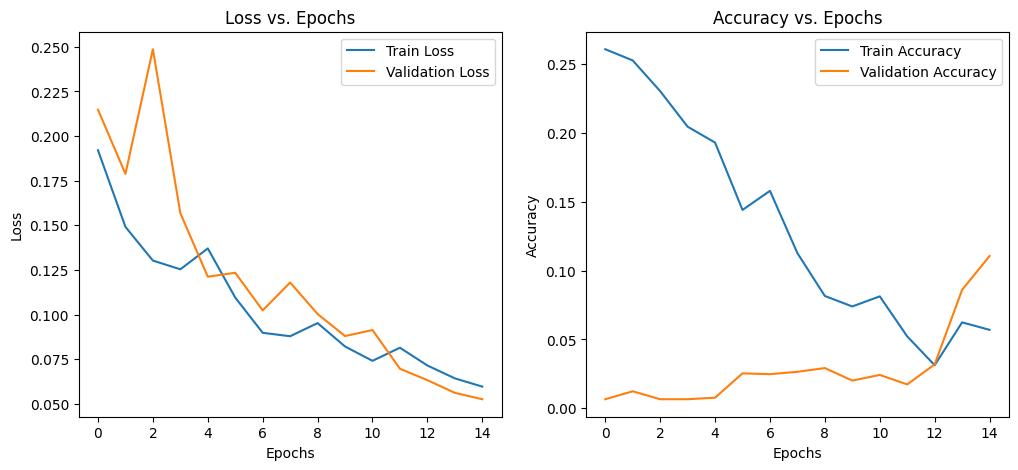

In [10]:
# Plotting
epochs = range(15)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')